# Complete Streamlined Collaboration Analysis: Human-Human-GPT vs Human-RL

This comprehensive notebook provides a streamlined version of the collaboration analysis, merging data from:
1. **Human-Human-GPT study** (3 conditions: human, gpt-4.1-mini, mixed types)
2. **Human-RL study** (2 conditions: individual rl, joint rl)

**Complete Analysis includes ALL 10 original figures:**
1. Collaboration success rates
2. Total steps analysis (main + by commitment status)
3. Questionnaire analysis (AI detection, collaboration rating, play again intention)
4. Commitment patterns (human + AI, main + by distance conditions)
5. Combined human-AI commitment analysis

All statistical comparisons and visualizations are preserved from the original analysis.

## Setup and Imports

In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
from scipy.stats import chi2_contingency
import ast
import glob
import os
from itertools import combinations
warnings.filterwarnings('ignore')

# Set publication standards
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.titlesize': 16,
    'font.family': 'Arial'
})

# Define consistent color scheme for all conditions
CONDITION_COLORS = {
    'human': '#2E86C1',        # Blue
    'gpt-4.1-mini': '#E74C3C', # Red
    'individual_rl': '#28B463', # Green
    'joint_rl': '#F39C12',     # Orange
    'joint-rl-realTime': '#8E44AD'  # Purple
}

print("Libraries loaded and styling configured!")

Libraries loaded and styling configured!


## Global Configuration and Utility Functions

In [287]:
# Global configuration
game_type_order = ["human", "gpt-4.1-mini", "individual_rl", "joint_rl", "joint-rl-realTime"]
game_type_labels = ['Human', 'GPT-4.1-mini', 'Individual RL', 'Joint RL', 'Joint RL RealTime']

def rename_distance_condition_human_ai(row, study_type):
    """Rename distanceCondition values to be more intuitive for human-AI games."""
    distance_condition = row.get('distanceCondition')

    if pd.isna(distance_condition) or distance_condition in ['no_new_goal', 'equal_to_both']:
        return distance_condition

    if study_type == 'Human-RL':
        mapping = {
            'closer_to_player1': 'closer_to_human',
            'closer_to_player2': 'closer_to_AI',
            'farther_to_player1': 'farther_to_human',
            'equal_to_player1': 'equal_to_human'
        }
        return mapping.get(distance_condition, distance_condition)

    elif study_type == 'Human-Human-GPT':
        human_index = row.get('humanPlayerIndex', 0)

        if human_index == 0:
            mapping = {
                'closer_to_player1': 'closer_to_human',
                'closer_to_player2': 'closer_to_AI',
                'farther_to_player1': 'farther_to_human',
                'equal_to_player1': 'equal_to_human'
            }
        else:
            mapping = {
                'closer_to_player1': 'closer_to_AI',
                'closer_to_player2': 'closer_to_human',
                'farther_to_player1': 'farther_to_AI',
                'equal_to_player1': 'equal_to_AI'
            }

        return mapping.get(distance_condition, distance_condition)

    return distance_condition

def calculate_human_commitment_2p3g_merged(row, study_type):
    """Calculate commitment for human player in 2P3G based on study and player index"""
    shared_goal = row.get('firstDetectedSharedGoal')

    if pd.isna(shared_goal):
        return np.nan

    if study_type == 'Human-Human-GPT':
        human_index = row.get('humanPlayerIndex')
        if pd.isna(human_index):
            human_index = 0

        if human_index == 0:
            human_final_goal = row.get('player1FinalReachedGoal')
        else:
            human_final_goal = row.get('player2FinalReachedGoal')

    elif study_type == 'Human-RL':
        human_final_goal = row.get('player1FinalReachedGoal')

    else:
        return np.nan

    if pd.isna(human_final_goal):
        return np.nan

    try:
        shared_goal = int(shared_goal)
        human_final_goal = int(human_final_goal)
        return 1 if shared_goal == human_final_goal else 0
    except (ValueError, TypeError):
        return np.nan

def calculate_ai_commitment_2p3g(row, study_type):
    """Calculate AI commitment in 2P3G as whether AI's final reached goal equals the first detected shared goal."""
    shared_goal = row.get('firstDetectedSharedGoal')
    if pd.isna(shared_goal):
        return np.nan

    if study_type == 'Human-RL':
        ai_final_goal = row.get('player2FinalReachedGoal')
    elif study_type == 'Human-Human-GPT':
        human_index = row.get('humanPlayerIndex')
        if pd.isna(human_index):
            human_index = 0
        ai_index = 1 if human_index == 0 else 0
        ai_final_goal = row.get('player1FinalReachedGoal') if ai_index == 0 else row.get('player2FinalReachedGoal')
    else:
        return np.nan

    if pd.isna(ai_final_goal):
        return np.nan

    try:
        shared_goal = int(shared_goal)
        ai_final_goal = int(ai_final_goal)
        return 1 if ai_final_goal == shared_goal else 0
    except (ValueError, TypeError):
        return np.nan

def extract_participant_id(file_id, study):
    """Extract participant ID from file name"""
    parts = file_id.split('_')
    if len(parts) >= 3:
        return parts[2]
    return file_id

def calculate_trajectory_steps(row):
    """Calculate total steps from trajectory lengths"""
    try:
        p1_traj = row['player1Trajectory']
        p2_traj = row['player2Trajectory']

        if isinstance(p1_traj, str):
            p1_traj = ast.literal_eval(p1_traj)
        if isinstance(p2_traj, str):
            p2_traj = ast.literal_eval(p2_traj)

        p1_steps = len(p1_traj) if p1_traj else 0
        p2_steps = len(p2_traj) if p2_traj else 0

        return p1_steps + p2_steps
    except:
        return 0

def is_valid_trajectory(trajectory):
    """Check if trajectory has valid consecutive steps (distance <= 1)"""
    try:
        if isinstance(trajectory, str):
            trajectory = ast.literal_eval(trajectory)

        if not trajectory or len(trajectory) < 2:
            return True

        for i in range(1, len(trajectory)):
            prev_pos = trajectory[i-1]
            curr_pos = trajectory[i]
            distance = abs(curr_pos[0] - prev_pos[0]) + abs(curr_pos[1] - prev_pos[1])
            if distance > 1:
                return False

        return True
    except:
        return False

print("✅ Utility functions defined")



✅ Utility functions defined


## Comprehensive Data Loading Functions

In [288]:
def load_all_data():
    """Load all datasets needed for complete analysis"""

    print("=== LOADING ALL DATASETS ===")

    # 1. Load Human-Human-GPT collaboration success data
    try:
        hh_gpt_success = pd.read_csv('human-human-with-gpt-fallback/collaboration_success_by_gameType_participants.csv')
        hh_gpt_success['study'] = 'Human-Human-GPT'
        hh_gpt_success = hh_gpt_success.rename(columns={'participant_id': 'participantID'})
        print(f"✅ Human-Human-GPT success data: {len(hh_gpt_success)} participants")
    except Exception as e:
        print(f"❌ Error loading HH-GPT success data: {e}")
        hh_gpt_success = pd.DataFrame()

    # 2. Load Human-RL data from Excel files
    try:
        rl_data_dir = Path('human-RLs/data-original')
        excel_files = [f for f in rl_data_dir.glob('*.xlsx') if not f.name.startswith('~$')]

        rl_data_frames = []
        for file in excel_files:
            try:
                df = pd.read_excel(file)
                participant_id = file.name.split('_')[2]
                df['participantID'] = participant_id
                df['file_id'] = file.name
                df['study'] = 'Human-RL'
                rl_data_frames.append(df)
            except Exception as e:
                print(f"Warning: Error loading {file.name}: {e}")

        # Load joint-rl-realTime data from Excel files
        joint_realtime_dir = Path('human-RLs/joint-rl-realTime')
        joint_realtime_files = [f for f in joint_realtime_dir.glob('*.xlsx') if not f.name.startswith('~$')]

        for file in joint_realtime_files:
            try:
                df = pd.read_excel(file)
                # Extract participant ID from filename or use a default
                try:
                    participant_id = file.name.split('_')[2]
                except:
                    participant_id = file.name.replace('.xlsx', '').replace('experiment_data_', '')
                df['participantID'] = participant_id
                df['file_id'] = file.name
                df['study'] = 'Human-RL'
                # Rename rlAgentType to joint-rl-realTime
                df['rlAgentType'] = 'joint-rl-realTime'
                rl_data_frames.append(df)
                print(f"✅ Loaded joint-rl-realTime data: {file.name} ({len(df)} trials)")
            except Exception as e:
                print(f"Warning: Error loading joint-rl-realTime {file.name}: {e}")

        if rl_data_frames:
            rl_combined_data = pd.concat(rl_data_frames, ignore_index=True)
            rl_filtered_data = rl_combined_data[rl_combined_data['experimentType'] == '2P3G'].copy()

            # Calculate success rates
            rl_success = rl_filtered_data.groupby(['participantID', 'rlAgentType'])['collaborationSucceeded'].mean().reset_index()
            rl_success['success_rate'] = rl_success['collaborationSucceeded']
            rl_success['game_type'] = rl_success['rlAgentType'].map({
                'individual': 'individual_rl',
                'joint': 'joint_rl',
                'joint-rl-realTime': 'joint-rl-realTime'
            })
            rl_success['study'] = 'Human-RL'

            print(f"✅ Human-RL success data: {len(rl_success)} participants")
            print(f"   Game types: {rl_success['game_type'].value_counts()}")
        else:
            rl_success = pd.DataFrame()
            rl_combined_data = pd.DataFrame()
            rl_filtered_data = pd.DataFrame()
    except Exception as e:
        print(f"❌ Error loading RL data: {e}")
        rl_success = pd.DataFrame()
        rl_combined_data = pd.DataFrame()
        rl_filtered_data = pd.DataFrame()

    # 3. Load Human-Human-GPT trial-level data
    try:
        classification_df = pd.read_csv('human-human-with-gpt-fallback/file_classification_summary.csv')
        hh_gpt_files = glob.glob('human-human-with-gpt-fallback/data-original/*.xlsx')

        hh_gpt_trial_data = []
        for file in hh_gpt_files:
            try:
                excel_file = pd.ExcelFile(file)
                if 'ExperimentData' in excel_file.sheet_names:
                    exp_df = pd.read_excel(file, sheet_name='ExperimentData')
                    exp_df['file_id'] = os.path.basename(file)
                    exp_df['study'] = 'Human-Human-GPT'

                    # Filter for 2P3G successful trials
                    trials_2p3g = exp_df[(exp_df['experimentType'] == '2P3G') & (exp_df['collaborationSucceeded'] == True)].copy()

                    if len(trials_2p3g) > 0:
                        # Clean trajectories
                        valid_p1 = trials_2p3g['player1Trajectory'].apply(is_valid_trajectory)
                        valid_p2 = trials_2p3g['player2Trajectory'].apply(is_valid_trajectory)
                        trials_2p3g = trials_2p3g[valid_p1 & valid_p2].copy()

                        if len(trials_2p3g) > 0:
                            # Calculate steps and rename distance conditions
                            trials_2p3g['total_steps'] = trials_2p3g.apply(calculate_trajectory_steps, axis=1)
                            trials_2p3g['distanceCondition_renamed'] = trials_2p3g.apply(
                                lambda row: rename_distance_condition_human_ai(row, 'Human-Human-GPT'), axis=1
                            )
                            trials_2p3g['human_commitment'] = trials_2p3g.apply(
                                lambda row: calculate_human_commitment_2p3g_merged(row, 'Human-Human-GPT'), axis=1
                            )
                            trials_2p3g['ai_commitment'] = trials_2p3g.apply(
                                lambda row: calculate_ai_commitment_2p3g(row, 'Human-Human-GPT'), axis=1
                            )
                            hh_gpt_trial_data.append(trials_2p3g)
            except Exception as e:
                print(f"Warning: Error loading HH-GPT trial data from {file}: {e}")

        if hh_gpt_trial_data:
            hh_gpt_combined_trials = pd.concat(hh_gpt_trial_data, ignore_index=True)
            # Merge with classification
            hh_gpt_combined_trials = hh_gpt_combined_trials.merge(
                classification_df[['file_name', 'game_type']],
                left_on='file_id', right_on='file_name', how='left'
            )
            print(f"✅ Human-Human-GPT trial data: {len(hh_gpt_combined_trials)} trials")
        else:
            hh_gpt_combined_trials = pd.DataFrame()
    except Exception as e:
        print(f"❌ Error loading HH-GPT trial data: {e}")
        hh_gpt_combined_trials = pd.DataFrame()

    # 4. Process RL trial-level data
    if not rl_filtered_data.empty:
        try:
            # Add distance renaming and commitment calculation
            rl_filtered_data['distanceCondition_renamed'] = rl_filtered_data.apply(
                lambda row: rename_distance_condition_human_ai(row, 'Human-RL'), axis=1
            )
            rl_filtered_data['human_commitment'] = rl_filtered_data.apply(
                lambda row: calculate_human_commitment_2p3g_merged(row, 'Human-RL'), axis=1
            )
            rl_filtered_data['ai_commitment'] = rl_filtered_data.apply(
                lambda row: calculate_ai_commitment_2p3g(row, 'Human-RL'), axis=1
            )
            rl_filtered_data['game_type'] = rl_filtered_data['rlAgentType'].map({
                'individual': 'individual_rl',
                'joint': 'joint_rl',
                'joint-rl-realTime': 'joint-rl-realTime'
            })
            rl_filtered_data['total_steps'] = rl_filtered_data.apply(calculate_trajectory_steps, axis=1)
            print(f"✅ Human-RL trial data processed: {len(rl_filtered_data)} trials")
        except Exception as e:
            print(f"❌ Error processing RL trial data: {e}")

    # 5. Load questionnaire data
    questionnaire_data = []

    # RL questionnaire data
    try:
        for file in glob.glob('human-RLs/data-original/*.xlsx'):
            excel_file = pd.ExcelFile(file)
            if 'Questionnaire Data' in excel_file.sheet_names and 'Experiment Data' in excel_file.sheet_names:
                quest_df = pd.read_excel(file, sheet_name='Questionnaire Data')
                exp_df = pd.read_excel(file, sheet_name='Experiment Data')

                if 'rlAgentType' in exp_df.columns and len(exp_df) > 0:
                    rl_agent_type = exp_df['rlAgentType'].iloc[0]
                    quest_df['study'] = 'Human-RL'
                    if rl_agent_type == 'individual':
                        quest_df['game_type'] = 'individual_rl'
                    elif rl_agent_type == 'joint':
                        quest_df['game_type'] = 'joint_rl'
                    elif rl_agent_type == 'joint-rl-realTime':
                        quest_df['game_type'] = 'joint-rl-realTime'
                    else:
                        quest_df['game_type'] = rl_agent_type
                    questionnaire_data.append(quest_df)

        # Load joint-rl-realTime questionnaire data
        for file in glob.glob('human-RLs/joint-rl-realTime/*.xlsx'):
            try:
                excel_file = pd.ExcelFile(file)
                if 'Questionnaire Data' in excel_file.sheet_names:
                    quest_df = pd.read_excel(file, sheet_name='Questionnaire Data')
                    quest_df['study'] = 'Human-RL'
                    quest_df['game_type'] = 'joint-rl-realTime'
                    questionnaire_data.append(quest_df)
                    print(f"✅ Loaded joint-rl-realTime questionnaire: {os.path.basename(file)}")
            except Exception as e:
                print(f"Warning: Error loading joint-rl-realTime questionnaire {file}: {e}")

    except Exception as e:
        print(f"Warning: Error loading RL questionnaire data: {e}")

    # HH-GPT questionnaire data
    try:
        for file in glob.glob('human-human-with-gpt-fallback/data-original/*.xlsx'):
            excel_file = pd.ExcelFile(file)
            if 'Questionnaire' in excel_file.sheet_names:
                quest_df = pd.read_excel(file, sheet_name='Questionnaire')
                quest_df['study'] = 'Human-Human-GPT'
                quest_df['file_id'] = os.path.basename(file)

                # Merge with classification
                file_class = classification_df[classification_df['file_name'] == os.path.basename(file)]
                if not file_class.empty:
                    quest_df['game_type'] = file_class['game_type'].iloc[0]
                    questionnaire_data.append(quest_df)
    except Exception as e:
        print(f"Warning: Error loading HH-GPT questionnaire data: {e}")

    # Combine all datasets
    datasets = {
        'collaboration_success': pd.concat([hh_gpt_success, rl_success], ignore_index=True) if not hh_gpt_success.empty and not rl_success.empty else pd.DataFrame(),
        'trial_data': pd.concat([hh_gpt_combined_trials, rl_filtered_data], ignore_index=True) if not hh_gpt_combined_trials.empty and not rl_filtered_data.empty else pd.DataFrame(),
        'questionnaire': pd.concat(questionnaire_data, ignore_index=True) if questionnaire_data else pd.DataFrame(),
        'rl_trial_data': rl_filtered_data,
        'hh_gpt_trial_data': hh_gpt_combined_trials
    }

    # Filter questionnaire to analysis game types
    if not datasets['questionnaire'].empty:
        datasets['questionnaire'] = datasets['questionnaire'][
            datasets['questionnaire']['game_type'].isin(game_type_order)
        ]

    print(f"\n✅ Data loading complete!")
    print(f"📊 Collaboration success: {len(datasets['collaboration_success'])} participants")
    print(f"📊 Trial data: {len(datasets['trial_data'])} trials")
    print(f"📊 Questionnaire: {len(datasets['questionnaire'])} responses")

    return datasets

# Load all data
data = load_all_data()
print("✅ All datasets loaded and ready for analysis!")

=== LOADING ALL DATASETS ===
✅ Human-Human-GPT success data: 50 participants
✅ Loaded joint-rl-realTime data: experiment_data_ 67630f751df95f8fb373e275_2025-09-30T19-23-45-667Z.xlsx (35 trials)
✅ Loaded joint-rl-realTime data: experiment_data_ 672bf480b98fd6d326fd1f69_2025-09-30T19-19-16-244Z.xlsx (35 trials)
✅ Loaded joint-rl-realTime data: experiment_data_ 66469ef793a8127e49ca1992_2025-09-30T19-30-14-966Z.xlsx (35 trials)
✅ Loaded joint-rl-realTime data: experiment_data_ 667178d77f8b6ed980c256ff_2025-09-30T19-20-29-183Z.xlsx (35 trials)
✅ Loaded joint-rl-realTime data: experiment_data_ 6751acc5dc78128951a34f1f_2025-09-30T19-12-21-369Z.xlsx (35 trials)
✅ Loaded joint-rl-realTime data: experiment_data_67630f751df95f8fb373e275_2025-09-30T19-39-50-935Z.xlsx (35 trials)
✅ Loaded joint-rl-realTime data: experiment_data_ 6480bfd6d433e2e158870605_2025-09-30T19-11-55-119Z.xlsx (35 trials)
✅ Loaded joint-rl-realTime data: experiment_data_ 57adbbe8bcf54e000152816b_2025-09-30T19-03-22-396Z.xlsx 

## 1. Collaboration Success Analysis

=== COLLABORATION SUCCESS ANALYSIS ===


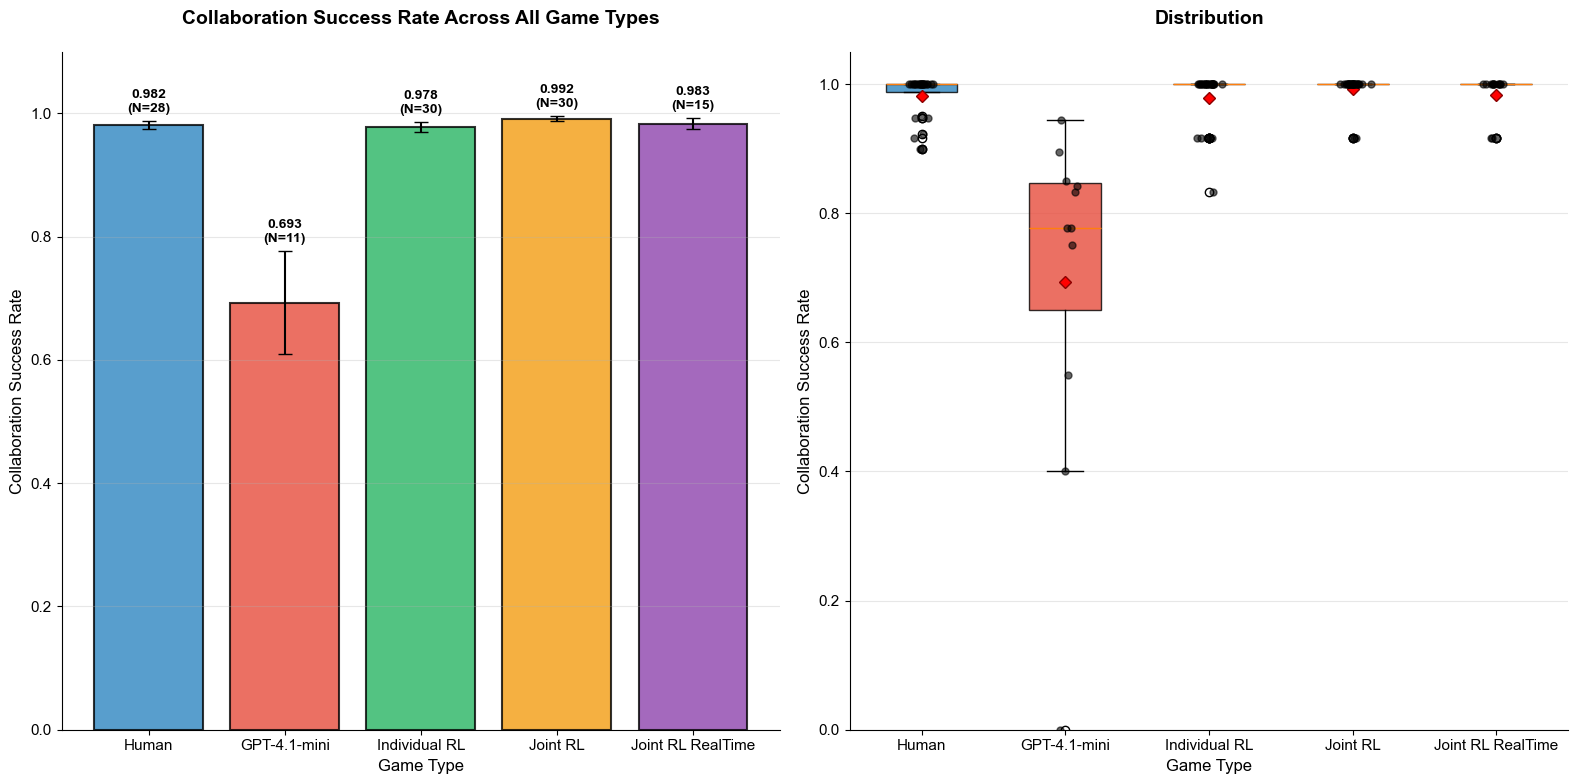


=== COLLABORATION SUCCESS STATISTICS ===
Human: M = 0.982, SD = 0.034, N = 28
GPT-4.1-mini: M = 0.693, SD = 0.278, N = 11
Individual RL: M = 0.978, SD = 0.043, N = 30
Joint RL: M = 0.992, SD = 0.025, N = 30
Joint RL RealTime: M = 0.983, SD = 0.035, N = 15


In [289]:
# Figure 2: Collaboration Success Analysis (merged_collaboration_success_analysis.png)
if not data['collaboration_success'].empty:
    print("=== COLLABORATION SUCCESS ANALYSIS ===")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    available_types = [gt for gt in game_type_order if gt in data['collaboration_success']['game_type'].values]
    available_labels = [game_type_labels[game_type_order.index(gt)] for gt in available_types]
    available_colors = [CONDITION_COLORS[gt] for gt in available_types]

    plot_data, plot_errors, plot_ns = [], [], []

    for game_type in available_types:
        data_subset = data['collaboration_success'][data['collaboration_success']['game_type'] == game_type]['success_rate']
        plot_data.append(data_subset.mean())
        plot_errors.append(data_subset.std() / np.sqrt(len(data_subset)))
        plot_ns.append(len(data_subset))

    # Bar plot
    bars = ax1.bar(available_labels, plot_data, yerr=plot_errors, capsize=5,
                   alpha=0.8, color=available_colors, edgecolor='black', linewidth=1.5)

    for bar, mean_val, error_val, n in zip(bars, plot_data, plot_errors, plot_ns):
        ax1.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.01,
                f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax1.set_title('Collaboration Success Rate Across All Game Types', fontweight='bold', pad=20)
    ax1.set_ylabel('Collaboration Success Rate')
    ax1.set_xlabel('Game Type')
    ax1.set_ylim(0, 1.1)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Box plot
    box_data = [data['collaboration_success'][data['collaboration_success']['game_type'] == gt]['success_rate'].values
                for gt in available_types]

    bp = ax2.boxplot(box_data, labels=available_labels, patch_artist=True,
                     showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

    for patch, color in zip(bp['boxes'], available_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)

    for i, game_type in enumerate(available_types):
        data_subset = data['collaboration_success'][data['collaboration_success']['game_type'] == game_type]['success_rate']
        x_positions = np.random.normal(i+1, 0.04, size=len(data_subset))
        ax2.scatter(x_positions, data_subset, color='black', alpha=0.6, s=25, zorder=3)

    ax2.set_title('Distribution', fontweight='bold', pad=20)
    ax2.set_ylabel('Collaboration Success Rate')
    ax2.set_xlabel('Game Type')
    ax2.set_ylim(0, 1.05)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('merged_collaboration_success_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Statistical analysis
    print("\n=== COLLABORATION SUCCESS STATISTICS ===")
    for game_type in available_types:
        data_subset = data['collaboration_success'][data['collaboration_success']['game_type'] == game_type]['success_rate']
        label = available_labels[available_types.index(game_type)]
        print(f"{label}: M = {data_subset.mean():.3f}, SD = {data_subset.std():.3f}, N = {len(data_subset)}")

else:
    print("❌ No collaboration success data available")

## 2. Total Steps Analysis

=== TOTAL STEPS ANALYSIS ===


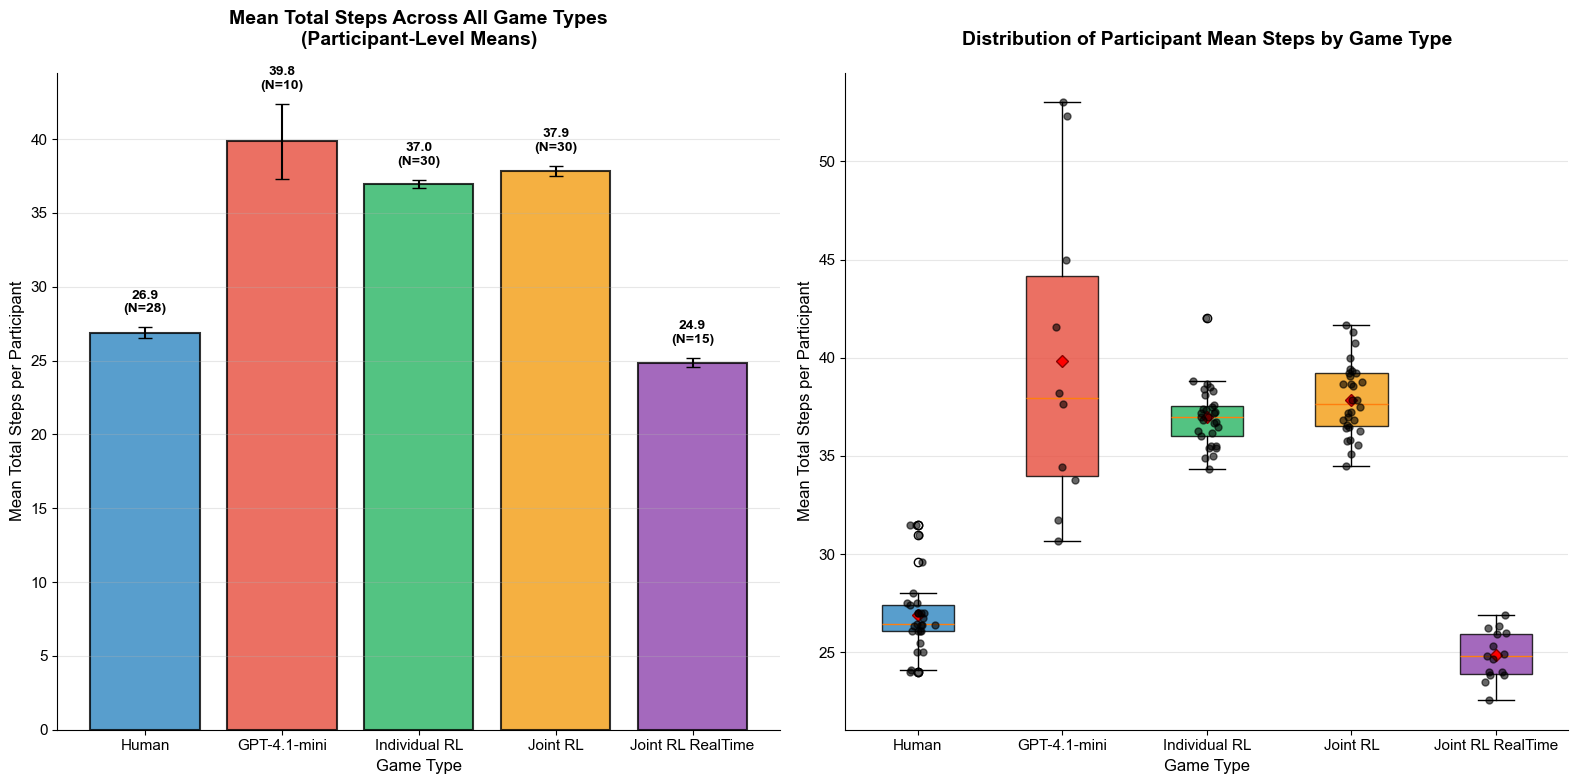

✅ Total steps analysis complete with 123 participants


In [290]:
# Figure 3: Total Steps Analysis (merged_total_steps_analysis.png)
if not data['trial_data'].empty:
    print("=== TOTAL STEPS ANALYSIS ===")

    # Calculate participant-level means
    steps_data = data['trial_data'][data['trial_data']['total_steps'] > 0].copy()
    steps_data['participant_id'] = steps_data.apply(lambda row: extract_participant_id(row['file_id'], row['study']), axis=1)

    participant_steps = steps_data.groupby(['participant_id', 'game_type', 'study'])['total_steps'].mean().reset_index()
    participant_steps['participant_mean_steps'] = participant_steps['total_steps']

    available_steps_types = [gt for gt in game_type_order if gt in participant_steps['game_type'].values]
    available_steps_labels = [game_type_labels[game_type_order.index(gt)] for gt in available_steps_types]
    available_steps_colors = [CONDITION_COLORS[gt] for gt in available_steps_types]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Bar plot
    plot_data, plot_errors, plot_ns = [], [], []

    for game_type in available_steps_types:
        participant_data = participant_steps[participant_steps['game_type'] == game_type]['participant_mean_steps']
        plot_data.append(participant_data.mean())
        plot_errors.append(participant_data.std() / np.sqrt(len(participant_data)))
        plot_ns.append(len(participant_data))

    bars = ax1.bar(available_steps_labels, plot_data, yerr=plot_errors, capsize=5,
                   alpha=0.8, color=available_steps_colors, edgecolor='black', linewidth=1.5)

    for bar, mean_val, error_val, n in zip(bars, plot_data, plot_errors, plot_ns):
        ax1.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + max(plot_data)*0.02,
                f'{mean_val:.1f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax1.set_title('Mean Total Steps Across All Game Types\n(Participant-Level Means)', fontweight='bold', pad=20)
    ax1.set_ylabel('Mean Total Steps per Participant')
    ax1.set_xlabel('Game Type')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Box plot
    box_data = [participant_steps[participant_steps['game_type'] == gt]['participant_mean_steps'].values
                for gt in available_steps_types]

    bp = ax2.boxplot(box_data, labels=available_steps_labels, patch_artist=True,
                     showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

    for patch, color in zip(bp['boxes'], available_steps_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)

    for i, game_type in enumerate(available_steps_types):
        participant_data = participant_steps[participant_steps['game_type'] == game_type]['participant_mean_steps']
        x_positions = np.random.normal(i+1, 0.04, size=len(participant_data))
        ax2.scatter(x_positions, participant_data, color='black', alpha=0.6, s=25, zorder=3)

    ax2.set_title('Distribution of Participant Mean Steps by Game Type', fontweight='bold', pad=20)
    ax2.set_ylabel('Mean Total Steps per Participant')
    ax2.set_xlabel('Game Type')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('merged_total_steps_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Total steps analysis complete with {len(participant_steps)} participants")

else:
    print("❌ No trial data available for steps analysis")

=== HUMAN TRAJECTORY STEPS ANALYSIS ===


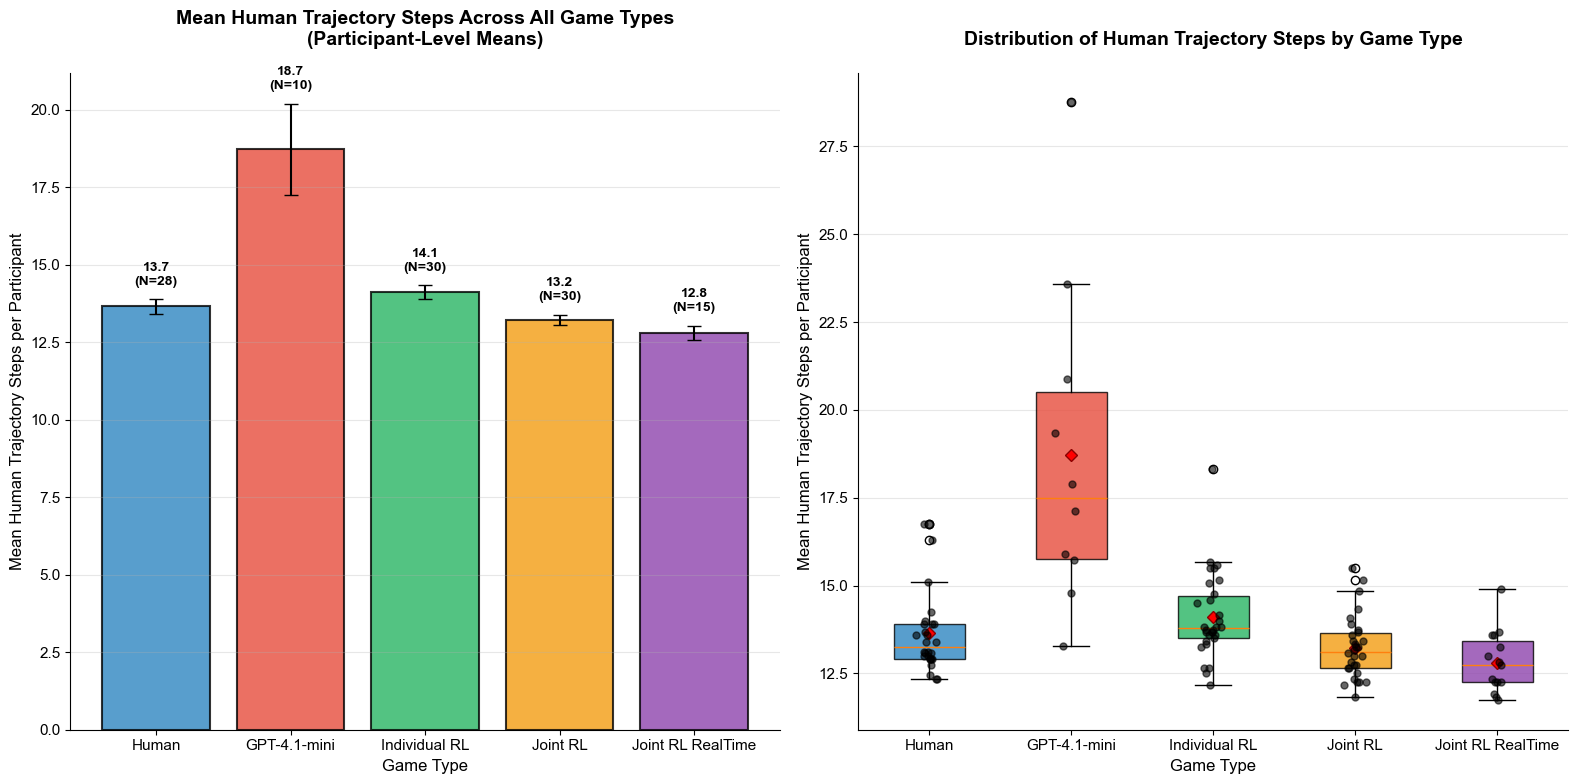


=== HUMAN TRAJECTORY STEPS STATISTICS ===
Human: M = 13.66, SD = 1.20, N = 28
GPT-4.1-mini: M = 18.73, SD = 4.65, N = 10
Individual RL: M = 14.12, SD = 1.23, N = 30
Joint RL: M = 13.23, SD = 0.90, N = 30
Joint RL RealTime: M = 12.81, SD = 0.87, N = 15
✅ Human trajectory steps analysis complete with 123 participants


In [ ]:
# Figure 2.5: Human Trajectory Steps Analysis
if not data['trial_data'].empty:
    print("=== HUMAN TRAJECTORY STEPS ANALYSIS ===")

    def get_human_trajectory_steps(row):
        """Get trajectory steps for human player based on game type and study"""
        try:
            study = row['study']
            game_type = row['game_type']

            # For Human-RL studies, human is always player 1
            if study == 'Human-RL':
                human_trajs = [row['player1Trajectory']]
            # For Human-Human-GPT studies, check if both players are human
            elif study == 'Human-Human-GPT':
                partner_type = row.get('partnerAgentType', '')
                if partner_type == 'human':
                    # Both players are human
                    human_trajs = [row['player1Trajectory'], row['player2Trajectory']]
                else:
                    # Only one player is human (the other is GPT)
                    human_index = row.get('humanPlayerIndex', 0)
                    if human_index == 0:
                        human_trajs = [row['player1Trajectory']]
                    else:
                        human_trajs = [row['player2Trajectory']]
            else:
                return 0

            # Calculate steps for each human trajectory
            total_steps = []
            for human_traj in human_trajs:
                # Parse trajectory if it's a string
                if isinstance(human_traj, str):
                    human_traj = ast.literal_eval(human_traj)

                if human_traj:
                    total_steps.append(len(human_traj))

            # Return average steps across all human players
            return np.mean(total_steps) if total_steps else 0

        except Exception as e:
            return 0

    # Calculate human trajectory steps for each trial (focus on new goal presented trials)
    human_steps_data = data['trial_data'][data['trial_data']['newGoalPresented'] == True].copy()
    human_steps_data['human_steps'] = human_steps_data.apply(get_human_trajectory_steps, axis=1)

    # Filter out invalid data
    human_steps_data = human_steps_data[human_steps_data['human_steps'] > 0].copy()

    print(f"📊 Analyzing {len(human_steps_data)} trials with new goal presented")

    if not human_steps_data.empty:
        # Calculate participant-level means
        human_steps_data['participant_id'] = human_steps_data.apply(
            lambda row: extract_participant_id(row['file_id'], row['study']), axis=1
        )

        participant_human_steps = human_steps_data.groupby(
            ['participant_id', 'game_type', 'study']
        )['human_steps'].mean().reset_index()
        participant_human_steps['mean_human_steps'] = participant_human_steps['human_steps']

        available_human_types = [gt for gt in game_type_order if gt in participant_human_steps['game_type'].values]
        available_human_labels = [game_type_labels[game_type_order.index(gt)] for gt in available_human_types]
        available_human_colors = [CONDITION_COLORS[gt] for gt in available_human_types]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

        # Bar plot
        plot_data, plot_errors, plot_ns = [], [], []

        for game_type in available_human_types:
            participant_data = participant_human_steps[participant_human_steps['game_type'] == game_type]['mean_human_steps']
            plot_data.append(participant_data.mean())
            plot_errors.append(participant_data.std() / np.sqrt(len(participant_data)))
            plot_ns.append(len(participant_data))

        bars = ax1.bar(available_human_labels, plot_data, yerr=plot_errors, capsize=5,
                       alpha=0.8, color=available_human_colors, edgecolor='black', linewidth=1.5)

        for bar, mean_val, error_val, n in zip(bars, plot_data, plot_errors, plot_ns):
            ax1.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + max(plot_data)*0.02,
                    f'{mean_val:.1f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

        ax1.set_title('Mean Human Trajectory Steps Across All Game Types\n(Participant-Level Means, New Goal Trials Only)', fontweight='bold', pad=20)
        ax1.set_ylabel('Mean Human Trajectory Steps per Participant')
        ax1.set_xlabel('Game Type')
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)

        # Box plot
        box_data = [participant_human_steps[participant_human_steps['game_type'] == gt]['mean_human_steps'].values
                    for gt in available_human_types]

        bp = ax2.boxplot(box_data, labels=available_human_labels, patch_artist=True,
                         showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

        for patch, color in zip(bp['boxes'], available_human_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.8)

        for i, game_type in enumerate(available_human_types):
            participant_data = participant_human_steps[participant_human_steps['game_type'] == game_type]['mean_human_steps']
            x_positions = np.random.normal(i+1, 0.04, size=len(participant_data))
            ax2.scatter(x_positions, participant_data, color='black', alpha=0.6, s=25, zorder=3)

        ax2.set_title('Distribution of Human Trajectory Steps by Game Type\n(New Goal Trials Only)', fontweight='bold', pad=20)
        ax2.set_ylabel('Mean Human Trajectory Steps per Participant')
        ax2.set_xlabel('Game Type')
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)

        plt.tight_layout()
        plt.savefig('merged_human_trajectory_steps_analysis_new_goal_trials.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Print statistics
        print("\n=== HUMAN TRAJECTORY STEPS STATISTICS (NEW GOAL TRIALS) ===")
        for game_type in available_human_types:
            participant_data = participant_human_steps[participant_human_steps['game_type'] == game_type]['mean_human_steps']
            label = available_human_labels[available_human_types.index(game_type)]
            print(f"{label}: M = {participant_data.mean():.2f}, SD = {participant_data.std():.2f}, N = {len(participant_data)}")

        print(f"✅ Human trajectory steps analysis complete (NEW GOAL TRIALS) with {len(participant_human_steps)} participants")
    else:
        print("❌ No valid human trajectory data available")
else:
    print("❌ No trial data available for human trajectory steps analysis")

## 2.6. Human Efficiency Analysis After New Goal Presentation


=== HUMAN EFFICIENCY ANALYSIS: HUMAN-HUMAN vs JOINT RL ===
Analyzing 413 trials from human-human and joint RL experiments...
Valid efficiency calculations: 413


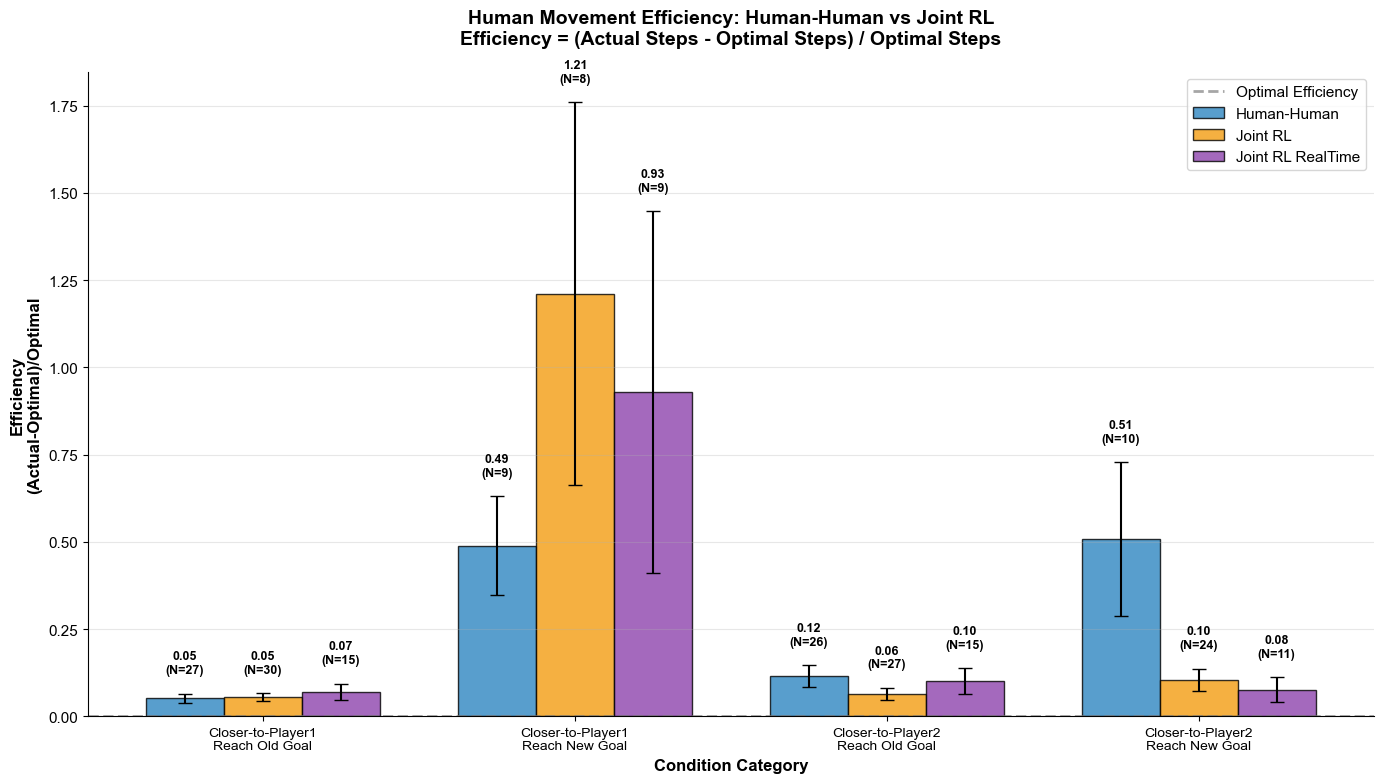

\n=== DETAILED EFFICIENCY STATISTICS ===
\nHuman-Human:
  Closer-to-Player1 Reach Old Goal: M = 0.052, SD = 0.066, N = 27
  Closer-to-Player1 Reach New Goal: M = 0.490, SD = 0.422, N = 9
  Closer-to-Player2 Reach Old Goal: M = 0.115, SD = 0.164, N = 26
  Closer-to-Player2 Reach New Goal: M = 0.508, SD = 0.696, N = 10
\nJoint RL:
  Closer-to-Player1 Reach Old Goal: M = 0.054, SD = 0.064, N = 30
  Closer-to-Player1 Reach New Goal: M = 1.211, SD = 1.551, N = 8
  Closer-to-Player2 Reach Old Goal: M = 0.064, SD = 0.093, N = 27
  Closer-to-Player2 Reach New Goal: M = 0.105, SD = 0.157, N = 24
\nJoint RL RealTime:
  Closer-to-Player1 Reach Old Goal: M = 0.070, SD = 0.091, N = 15
  Closer-to-Player1 Reach New Goal: M = 0.930, SD = 1.555, N = 9
  Closer-to-Player2 Reach Old Goal: M = 0.101, SD = 0.146, N = 15
  Closer-to-Player2 Reach New Goal: M = 0.077, SD = 0.116, N = 11
\n✅ Human efficiency analysis complete with 211 participant-condition combinations


In [ ]:
# Figure 2.6: Human Efficiency Analysis - Human-Human vs Joint RL (New Goal Trials)
if not data['trial_data'].empty:
    print("=== HUMAN EFFICIENCY ANALYSIS: HUMAN-HUMAN vs JOINT RL (NEW GOAL TRIALS) ===")

    def calculate_manhattan_distance(pos1, pos2):
        """Calculate Manhattan distance between two positions"""
        if not pos1 or not pos2 or len(pos1) < 2 or len(pos2) < 2:
            return float('inf')
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

    def get_human_efficiency_data_detailed(row):
        """Calculate human efficiency with detailed goal tracking"""
        try:
            study = row['study']
            game_type = row['game_type']

            # Get human trajectory and goals
            human_data_list = []
            if study == 'Human-RL':
                # Human is always player 1 in Human-RL studies
                human_data_list.append({
                    'traj': row['player1Trajectory'],
                    'final_goal': row.get('player1FinalReachedGoal'),
                    'commitment': row.get('human_commitment', np.nan)
                })
            elif study == 'Human-Human-GPT':
                partner_type = row.get('partnerAgentType', '')
                if partner_type == 'human':
                    # Both players are human
                    human_data_list.append({
                        'traj': row['player1Trajectory'],
                        'final_goal': row.get('player1FinalReachedGoal'),
                        'commitment': row.get('player1_commitment', np.nan)
                    })
                    human_data_list.append({
                        'traj': row['player2Trajectory'],
                        'final_goal': row.get('player2FinalReachedGoal'),
                        'commitment': row.get('player2_commitment', np.nan)
                    })
                else:
                    # Only one player is human (the other is GPT)
                    human_index = row.get('humanPlayerIndex', 0)
                    if human_index == 0:
                        human_data_list.append({
                            'traj': row['player1Trajectory'],
                            'final_goal': row.get('player1FinalReachedGoal'),
                            'commitment': row.get('human_commitment', np.nan)
                        })
                    else:
                        human_data_list.append({
                            'traj': row['player2Trajectory'],
                            'final_goal': row.get('player2FinalReachedGoal'),
                            'commitment': row.get('human_commitment', np.nan)
                        })
            else:
                return None

            # Process each human's data
            results = []
            for human_data in human_data_list:
                human_traj = human_data['traj']
                human_final_goal = human_data['final_goal']
                human_commitment = human_data['commitment']

                # Parse trajectory if it's a string
                if isinstance(human_traj, str):
                    try:
                        human_traj = ast.literal_eval(human_traj)
                    except:
                        continue

                if not human_traj or len(human_traj) < 2:
                    continue

                # Get starting position and calculate actual steps
                start_pos = human_traj[0]
                final_pos = human_traj[-1]
                actual_steps = len(human_traj) - 1  # Subtract 1 because trajectory includes starting position

                # Calculate optimal steps to final position
                optimal_steps = calculate_manhattan_distance(start_pos, final_pos)

                if optimal_steps == 0:
                    continue  # Already at goal

                # Calculate efficiency using excess steps logic
                # Normalize to 0-100 scale where 100 = most efficient (optimal)
                excess_steps = actual_steps - optimal_steps
                efficiency = (1 - excess_steps / actual_steps) * 100

                # Determine if human reached old goal (shared goal) or new goal
                reached_old_goal = 1 if (not pd.isna(human_commitment) and human_commitment == 1) else 0
                reached_new_goal = 1 - reached_old_goal if not pd.isna(human_commitment) else np.nan

                results.append({
                    'actual_steps': actual_steps,
                    'optimal_steps': optimal_steps,
                    'efficiency': efficiency,
                    'human_commitment': human_commitment,
                    'reached_old_goal': reached_old_goal,
                    'reached_new_goal': reached_new_goal
                })

            if not results:
                return None

            # Average metrics across all humans
            distance_condition = row.get('distanceCondition', 'unknown')

            return {
                'participant_id': extract_participant_id(row['file_id'], study),
                'game_type': game_type,
                'study': study,
                'distance_condition': distance_condition,
                'actual_steps': np.mean([r['actual_steps'] for r in results]),
                'optimal_steps': np.mean([r['optimal_steps'] for r in results]),
                'efficiency': np.mean([r['efficiency'] for r in results]),
                'human_commitment': np.nanmean([r['human_commitment'] for r in results]),
                'reached_old_goal': np.mean([r['reached_old_goal'] for r in results]),
                'reached_new_goal': np.nanmean([r['reached_new_goal'] for r in results])
            }

        except Exception as e:
            return None

    # Filter for human-human and both joint RL experiments with new goal presented
    target_data = data['trial_data'][
        (data['trial_data']['game_type'].isin(['human', 'joint_rl', 'joint-rl-realTime'])) &  # Focus on human-human and both joint RL versions
        (data['trial_data']['newGoalPresented'] == True) &  # Only trials with new goal presented
        (data['trial_data']['distanceCondition'].isin(['closer_to_player1', 'closer_to_player2'])) &
        (data['trial_data']['collaborationSucceeded'] == True) &  # Only successful trials
        (~pd.isna(data['trial_data']['human_commitment']))  # Must have commitment data
    ].copy()

    if not target_data.empty:
        print(f"Analyzing {len(target_data)} trials from human-human and joint RL experiments...")

        # Calculate efficiency for each trial
        efficiency_results = []
        for _, row in target_data.iterrows():
            result = get_human_efficiency_data_detailed(row)
            if result is not None:
                efficiency_results.append(result)

        if efficiency_results:
            efficiency_df = pd.DataFrame(efficiency_results)

            # Filter out extreme outliers
            efficiency_df = efficiency_df[
                (efficiency_df['efficiency'] >= -0.5) &
                (efficiency_df['efficiency'] <= 5.0)
            ].copy()

            print(f"Valid efficiency calculations: {len(efficiency_df)}")

            if not efficiency_df.empty:
                # Create the 4 categories as requested
                def create_condition_category(row):
                    distance_cond = row['distance_condition']
                    reached_old = row['reached_old_goal']

                    if distance_cond == 'closer_to_player1':
                        if reached_old == 1:
                            return 'Closer-to-Player1\nReach Old Goal'
                        else:
                            return 'Closer-to-Player1\nReach New Goal'
                    elif distance_cond == 'closer_to_player2':
                        if reached_old == 1:
                            return 'Closer-to-Player2\nReach Old Goal'
                        else:
                            return 'Closer-to-Player2\nReach New Goal'
                    else:
                        return 'Other'

                efficiency_df['condition_category'] = efficiency_df.apply(create_condition_category, axis=1)

                # Filter out 'Other' category
                efficiency_df = efficiency_df[efficiency_df['condition_category'] != 'Other'].copy()

                # Calculate participant-level means
                participant_efficiency = efficiency_df.groupby(
                    ['participant_id', 'game_type', 'study', 'condition_category']
                ).agg({
                    'efficiency': 'mean',
                    'actual_steps': 'mean',
                    'optimal_steps': 'mean'
                }).reset_index()

                # Define the specific order for x-axis categories
                category_order = [
                    'Closer-to-Player1\nReach Old Goal',
                    'Closer-to-Player1\nReach New Goal',
                    'Closer-to-Player2\nReach Old Goal',
                    'Closer-to-Player2\nReach New Goal'
                ]

                # Filter to human-human and both joint RL versions
                target_games = ['human', 'joint_rl', 'joint-rl-realTime']
                game_labels_map = {'human': 'Human-Human', 'joint_rl': 'Joint RL', 'joint-rl-realTime': 'Joint RL RealTime'}
                game_colors_map = {'human': CONDITION_COLORS['human'], 'joint_rl': CONDITION_COLORS['joint_rl'], 'joint-rl-realTime': CONDITION_COLORS['joint-rl-realTime']}

                available_games = [gt for gt in target_games if gt in participant_efficiency['game_type'].values]

                if len(available_games) > 0:
                    fig, ax = plt.subplots(1, 1, figsize=(14, 8))

                    # Prepare data for grouped bar plot
                    x_positions = np.arange(len(category_order))
                    bar_width = 0.25  # Reduced bar width to prevent overlap
                    n_games = len(available_games)

                    # Calculate offset for centering bars
                    offset = (n_games - 1) * bar_width / 2

                    for i, game_type in enumerate(available_games):
                        game_data = participant_efficiency[participant_efficiency['game_type'] == game_type]
                        game_label = game_labels_map[game_type]
                        game_color = game_colors_map[game_type]

                        plot_data, plot_errors, plot_ns = [], [], []

                        for category in category_order:
                            category_data = game_data[game_data['condition_category'] == category]['efficiency']
                            if len(category_data) > 0:
                                plot_data.append(category_data.mean())
                                plot_errors.append(category_data.std() / np.sqrt(len(category_data)))
                                plot_ns.append(len(category_data))
                            else:
                                plot_data.append(0)
                                plot_errors.append(0)
                                plot_ns.append(0)

                        # Calculate x positions for this game type
                        bar_x_positions = x_positions + (i * bar_width) - offset

                        # Plot bars
                        bars = ax.bar(bar_x_positions, plot_data, bar_width,
                                     yerr=plot_errors, capsize=5, alpha=0.8,
                                     color=game_color, edgecolor='black', linewidth=1,
                                     label=game_label)

                        # Add value labels on bars
                        for j, (bar, mean_val, error_val, n) in enumerate(zip(bars, plot_data, plot_errors, plot_ns)):
                            if n > 0:  # Only add label if there's data
                                ax.text(bar.get_x() + bar.get_width()/2.,
                                        mean_val + error_val + 0.05,
                                        f'{mean_val:.2f}\n(N={n})', ha='center', va='bottom',
                                        fontweight='bold', fontsize=9)

                    # Customize plot
                    ax.set_xlabel('Condition Category', fontsize=12, fontweight='bold')
                    ax.set_ylabel('Efficiency (%)\n(100 = Optimal)', fontsize=12, fontweight='bold')
                    ax.set_title('Human Movement Efficiency: Human-Human vs Joint RL (New Goal Trials)\n' +
                               'Efficiency = (1 - Excess Steps / Actual Steps) × 100',
                               fontsize=14, fontweight='bold', pad=20)

                    # Set x-axis
                    ax.set_xticks(x_positions)
                    ax.set_xticklabels(category_order, fontsize=10)

                    # Add horizontal line at efficiency = 100% (optimal)
                    ax.axhline(y=100, color='gray', linestyle='--', alpha=0.7,
                             linewidth=2, label='Optimal Efficiency (100%)')
                    ax.set_ylim(0, 105)  # Set y-axis limits for percentage scale

                    # Styling
                    ax.grid(True, alpha=0.3, axis='y')
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                    ax.legend(fontsize=11)

                    plt.tight_layout()
                    plt.savefig('human_efficiency_human_vs_joint_rl_by_goal_choice.png', dpi=300, bbox_inches='tight')
                    plt.show()

                    # Print detailed statistics
                    print("\\n=== DETAILED EFFICIENCY STATISTICS ===")
                    for game_type in available_games:
                        game_label = game_labels_map[game_type]
                        game_data = participant_efficiency[participant_efficiency['game_type'] == game_type]
                        print(f"\\n{game_label}:")
                        for category in category_order:
                            category_data = game_data[game_data['condition_category'] == category]['efficiency']
                            if len(category_data) > 0:
                                print(f"  {category.replace(chr(10), ' ')}: M = {category_data.mean():.3f}, " +
                                     f"SD = {category_data.std():.3f}, N = {len(category_data)}")

                    print(f"\\n✅ Human efficiency analysis complete with {len(participant_efficiency)} participant-condition combinations")
                else:
                    print("❌ No valid game types for efficiency analysis")
            else:
                print("❌ No valid efficiency data after filtering")
        else:
            print("❌ No efficiency calculations could be performed")
    else:
        print("❌ No target experiment data available")
else:
    print("❌ No trial data available for efficiency analysis")


## 2.7. Representative Trajectory Visualizations for Key Efficiency Differences


=== TRAJECTORY VISUALIZATIONS: KEY EFFICIENCY DIFFERENCES ===
Debug: newGoalPresentedTime=7.0, step_idx=7, traj1_len=13, traj2_len=28
Debug: Plotted P1 marker at step 7: (8, 6)
Debug: Plotted P2 marker at step 7: (2, 5)
Debug: newGoalPresentedTime=5.0, step_idx=5, traj1_len=18, traj2_len=16
Debug: Plotted P1 marker at step 5: (10, 6)
Debug: Plotted P2 marker at step 5: (1, 5)
Debug: newGoalPresentedTime=5.0, step_idx=5, traj1_len=14, traj2_len=30
Debug: Plotted P1 marker at step 5: (6, 6)
Debug: Plotted P2 marker at step 5: (13, 5)
Debug: newGoalPresentedTime=6.0, step_idx=6, traj1_len=19, traj2_len=18
Debug: Plotted P1 marker at step 6: (7, 4)
Debug: Plotted P2 marker at step 6: (9, 13)
Debug: newGoalPresentedTime=8.0, step_idx=8, traj1_len=13, traj2_len=28
Debug: Plotted P1 marker at step 8: (8, 7)
Debug: Plotted P2 marker at step 8: (9, 12)
Debug: newGoalPresentedTime=2.0, step_idx=2, traj1_len=15, traj2_len=14
Debug: Plotted P1 marker at step 2: (9, 3)
Debug: Plotted P2 marker at s

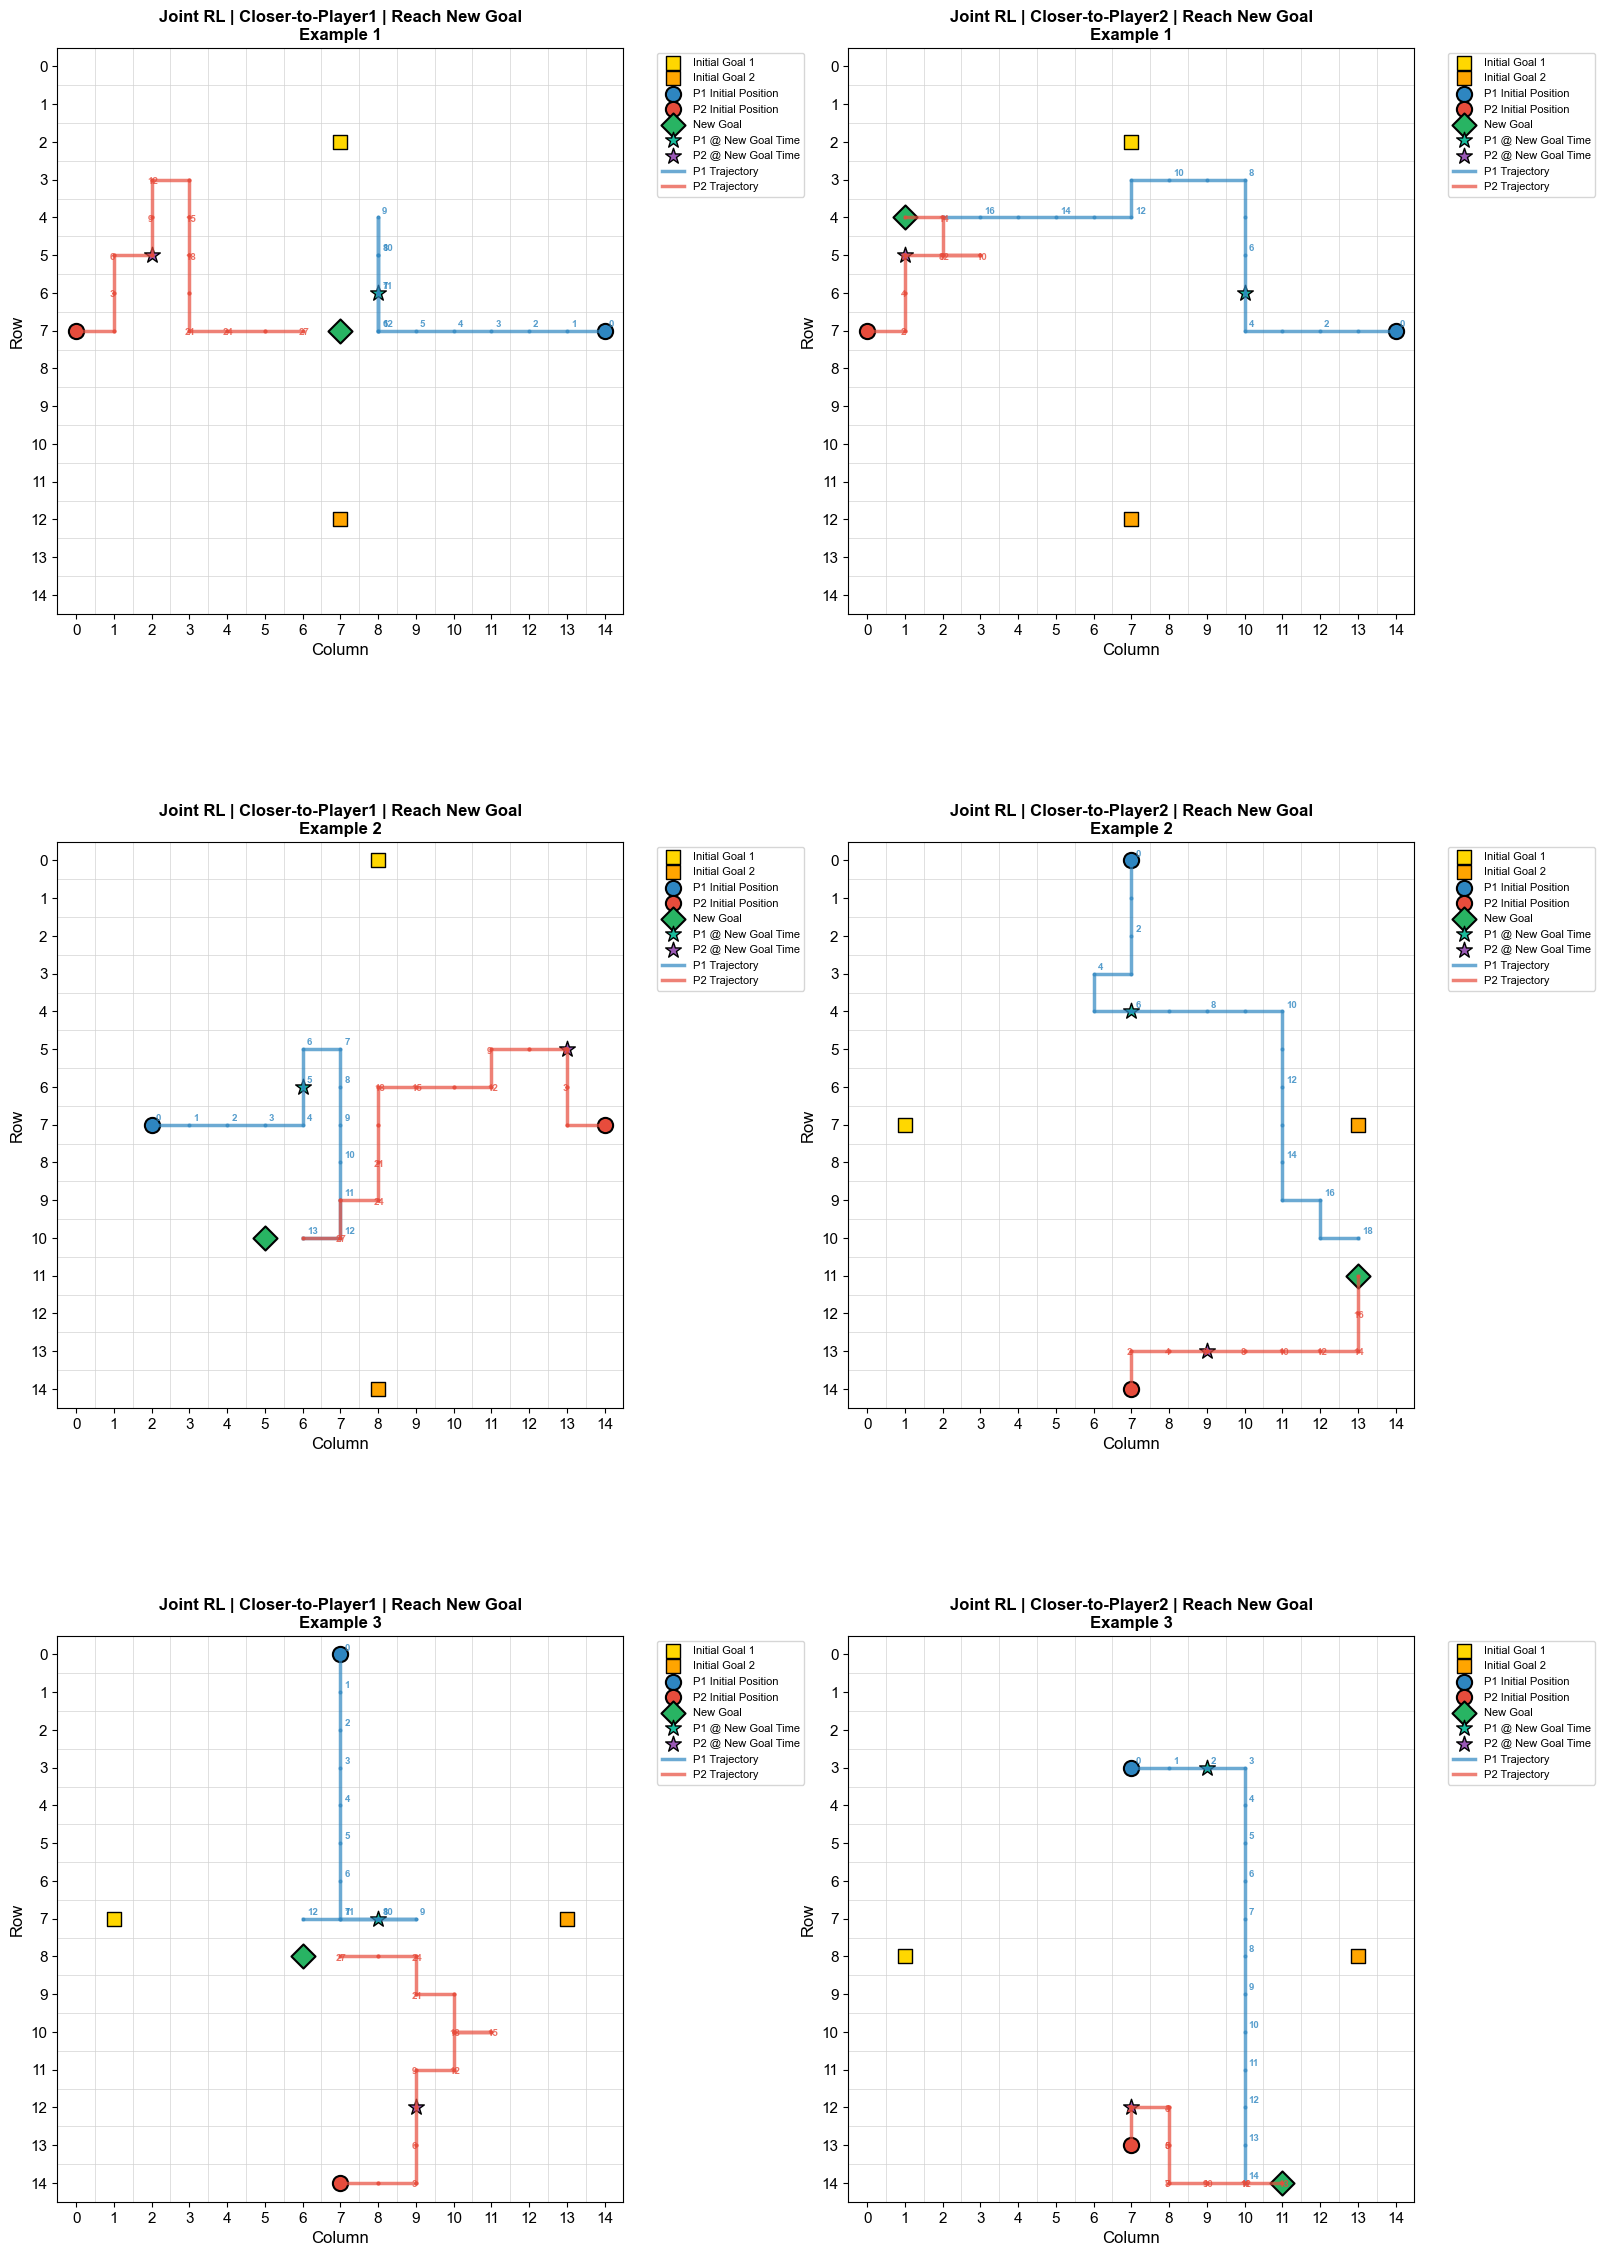

In [293]:
# Figure 2.7: Trajectory Visualizations for Key Efficiency Conditions
# We will sample one representative trial for each of the two conditions:
# 1) joint_rl, closer_to_player1, reach new goal
# 2) joint-rl-realTime, closer_to_player2, reach new goal

if not data['trial_data'].empty:
    print("=== TRAJECTORY VISUALIZATIONS: KEY EFFICIENCY DIFFERENCES ===")

    import random

    def parse_traj(traj):
        if isinstance(traj, str):
            try:
                return ast.literal_eval(traj)
            except Exception:
                return []
        return traj if isinstance(traj, list) else []

    def plot_trial(ax, trial_row, title):
        # Extract and parse trajectories
        p1_traj = parse_traj(trial_row.get('player1Trajectory', []))
        p2_traj = parse_traj(trial_row.get('player2Trajectory', []))

        # Set up 15x15 grid
        grid_size = 15
        ax.set_xlim(-0.5, grid_size - 0.5)
        ax.set_ylim(-0.5, grid_size - 0.5)
        ax.set_aspect('equal')
        ax.invert_yaxis()

        # Create grid lines
        for i in range(grid_size + 1):
            ax.axhline(i - 0.5, color='lightgray', linewidth=0.5)
            ax.axvline(i - 0.5, color='lightgray', linewidth=0.5)

        # Set ticks
        ax.set_xticks(range(grid_size))
        ax.set_yticks(range(grid_size))

        # 1. Plot initial goal positions (squares)
        try:
            # Try to get initial goals from target1 and target2 fields
            target1 = trial_row.get('target1')
            target2 = trial_row.get('target2')

            if isinstance(target1, str):
                target1 = ast.literal_eval(target1)
            if isinstance(target2, str):
                target2 = ast.literal_eval(target2)

            if isinstance(target1, (list, tuple)) and len(target1) >= 2:
                ax.scatter([target1[1]], [target1[0]], s=100, marker='s', color='gold', edgecolor='black', linewidth=1, label='Initial Goal 1')
            if isinstance(target2, (list, tuple)) and len(target2) >= 2:
                ax.scatter([target2[1]], [target2[0]], s=100, marker='s', color='orange', edgecolor='black', linewidth=1, label='Initial Goal 2')
        except Exception:
            pass

        # 2. Plot players' initial positions (circles)
        if p1_traj and len(p1_traj) > 0:
            xs1 = [p[1] for p in p1_traj]
            ys1 = [p[0] for p in p1_traj]
            ax.scatter([xs1[0]], [ys1[0]], s=120, marker='o', color='#2E86C1', edgecolor='black', linewidth=1.5, label='P1 Initial Position')
        else:
            xs1, ys1 = [], []

        if p2_traj and len(p2_traj) > 0:
            xs2 = [p[1] for p in p2_traj]
            ys2 = [p[0] for p in p2_traj]
            ax.scatter([xs2[0]], [ys2[0]], s=120, marker='o', color='#E74C3C', edgecolor='black', linewidth=1.5, label='P2 Initial Position')
        else:
            xs2, ys2 = [], []

        # 3. Plot new goal position
        new_goal_pos = trial_row.get('newGoalPosition')
        if isinstance(new_goal_pos, str):
            try:
                new_goal_pos = ast.literal_eval(new_goal_pos)
            except Exception:
                new_goal_pos = None

        if isinstance(new_goal_pos, (list, tuple)) and len(new_goal_pos) >= 2:
            ax.scatter([new_goal_pos[1]], [new_goal_pos[0]], s=150, marker='D', color='#28B463', edgecolor='black', linewidth=1.5, label='New Goal')

                # 4. Plot players' positions when new goal appears
        try:
            ng_time = trial_row.get('newGoalPresentedTime', np.nan)

            # Use the newGoalPresentedTime directly as step index if it's available
            if pd.notna(ng_time) and xs1 and xs2:
                # newGoalPresentedTime should be the step index when new goal was presented
                step_idx = int(ng_time)

                # Debug info
                print(f"Debug: newGoalPresentedTime={ng_time}, step_idx={step_idx}, traj1_len={len(xs1)}, traj2_len={len(xs2)}")

                # Make sure step index is within trajectory bounds
                if 0 <= step_idx < len(xs1):
                    ax.scatter([xs1[step_idx]], [ys1[step_idx]], s=140, marker='*', color='#1ABC9C', edgecolor='black', linewidth=1, label='P1 @ New Goal Time')
                    print(f"Debug: Plotted P1 marker at step {step_idx}: ({xs1[step_idx]}, {ys1[step_idx]})")

                if 0 <= step_idx < len(xs2):
                    ax.scatter([xs2[step_idx]], [ys2[step_idx]], s=140, marker='*', color='#9B59B6', edgecolor='black', linewidth=1, label='P2 @ New Goal Time')
                    print(f"Debug: Plotted P2 marker at step {step_idx}: ({xs2[step_idx]}, {ys2[step_idx]})")
            else:
                print(f"Debug: Cannot plot new goal markers - ng_time={ng_time}, xs1_len={len(xs1) if xs1 else 0}, xs2_len={len(xs2) if xs2 else 0}")
        except Exception as e:
            print(f"Debug: Exception in new goal plotting: {e}")

        # 5. Plot trajectories (lines with small markers and step numbers)
        if xs1 and ys1 and len(xs1) > 1:
            ax.plot(xs1, ys1, '-', color='#2E86C1', linewidth=2.5, alpha=0.7, label='P1 Trajectory')
            ax.plot(xs1, ys1, 'o', color='#2E86C1', markersize=2, alpha=0.6)

            # Add step numbers for P1 (every few steps to avoid clutter)
            step_interval = max(1, len(xs1) // 8)  # Show about 8 step numbers
            for i in range(0, len(xs1), step_interval):
                ax.annotate(str(i), (xs1[i], ys1[i]), xytext=(3, 3), textcoords='offset points',
                           fontsize=7, color='#2E86C1', fontweight='bold', alpha=0.8)

        if xs2 and ys2 and len(xs2) > 1:
            ax.plot(xs2, ys2, '-', color='#E74C3C', linewidth=2.5, alpha=0.7, label='P2 Trajectory')
            ax.plot(xs2, ys2, 'o', color='#E74C3C', markersize=2, alpha=0.6)

            # Add step numbers for P2 (every few steps to avoid clutter)
            step_interval = max(1, len(xs2) // 8)  # Show about 8 step numbers
            for i in range(0, len(xs2), step_interval):
                ax.annotate(str(i), (xs2[i], ys2[i]), xytext=(-3, -3), textcoords='offset points',
                           fontsize=7, color='#E74C3C', fontweight='bold', alpha=0.8)

        # Titles and legend
        ax.set_title(title, fontweight='bold', fontsize=12)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax.set_xlabel('Column')
        ax.set_ylabel('Row')

    # Build a helper dataframe focusing only on joint_rl
    target = data['trial_data'][
        (data['trial_data']['game_type'] == 'joint_rl') &
        (data['trial_data']['distanceCondition'].isin(['closer_to_player1', 'closer_to_player2'])) &
        (data['trial_data']['collaborationSucceeded'] == True) &
        (~pd.isna(data['trial_data']['human_commitment']))
    ].copy()

    def reached_old(row):
        return 1 if (not pd.isna(row.get('human_commitment')) and row.get('human_commitment') == 1) else 0

    target['reached_old_goal'] = target.apply(reached_old, axis=1)
    target['reached_new_goal'] = 1 - target['reached_old_goal']

        # Condition A: joint_rl, closer_to_player1, reach new goal
    condA = target[(target['game_type'] == 'joint_rl') &
                   (target['distanceCondition'] == 'closer_to_player1') &
                   (target['reached_new_goal'] == 1)]

    # Condition B: joint_rl, closer_to_player2, reach new goal
    condB = target[(target['game_type'] == 'joint_rl') &
                   (target['distanceCondition'] == 'closer_to_player2') &
                   (target['reached_new_goal'] == 1)]

    # Sample 3 trials from each condition if available
    sampleA = condA.sample(min(3, len(condA)), random_state=42) if len(condA) > 0 else None
    sampleB = condB.sample(min(3, len(condB)), random_state=43) if len(condB) > 0 else None

    # Create 3x2 subplot grid for 6 examples total (3 rows, 2 columns)
    fig, axes = plt.subplots(3, 2, figsize=(16, 24))

    # Plot 3 examples from each condition side by side
    for row in range(3):
        # Left column: Closer-to-Player1
        if sampleA is not None and row < len(sampleA):
            trial_row = sampleA.iloc[row]
            title = f'Joint RL | Closer-to-Player1 | Reach New Goal\nExample {row+1}'
            plot_trial(axes[row, 0], trial_row, title)
        else:
            axes[row, 0].axis('off')
            axes[row, 0].text(0.5, 0.5, 'No sample\navailable',
                             ha='center', va='center', fontsize=12)

        # Right column: Closer-to-Player2
        if sampleB is not None and row < len(sampleB):
            trial_row = sampleB.iloc[row]
            title = f'Joint RL | Closer-to-Player2 | Reach New Goal\nExample {row+1}'
            plot_trial(axes[row, 1], trial_row, title)
        else:
            axes[row, 1].axis('off')
            axes[row, 1].text(0.5, 0.5, 'No sample\navailable',
                             ha='center', va='center', fontsize=12)

    plt.tight_layout()
    plt.savefig('joint_rl_trajectory_comparison_6_examples.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("❌ No trial data available for trajectory visualization")


## 4. Questionnaire Analysis (AI Detection, Collaboration Rating, Play Again)

=== COMPREHENSIVE QUESTIONNAIRE ANALYSIS ===
Questionnaire responses: 114
Game types: game_type
joint_rl             30
individual_rl        30
human                28
joint-rl-realTime    15
gpt-4.1-mini         11
Name: count, dtype: int64


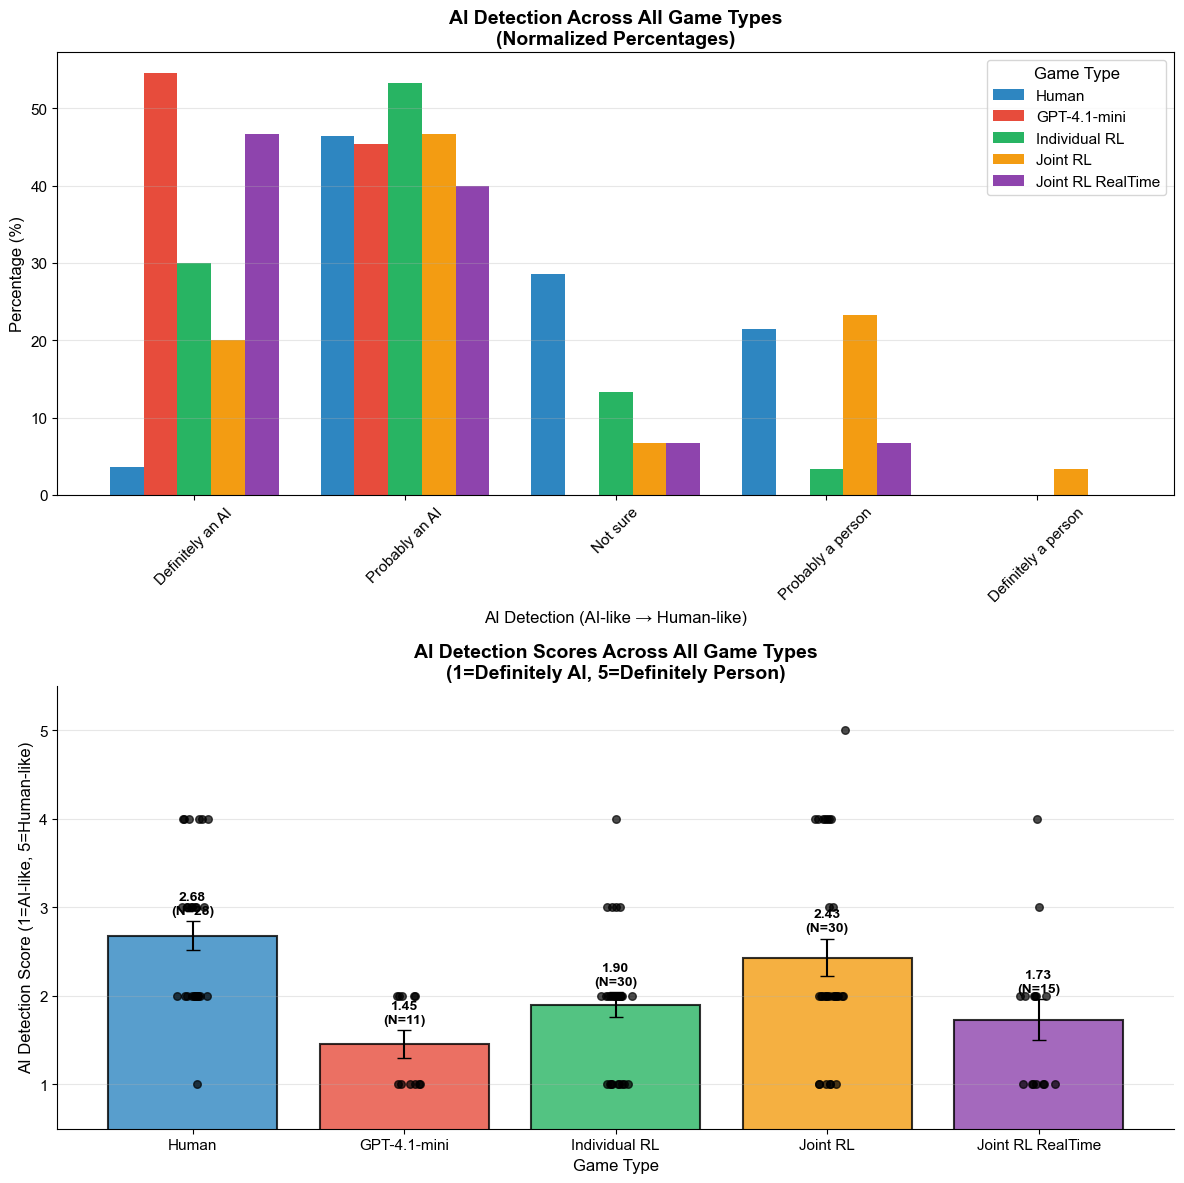

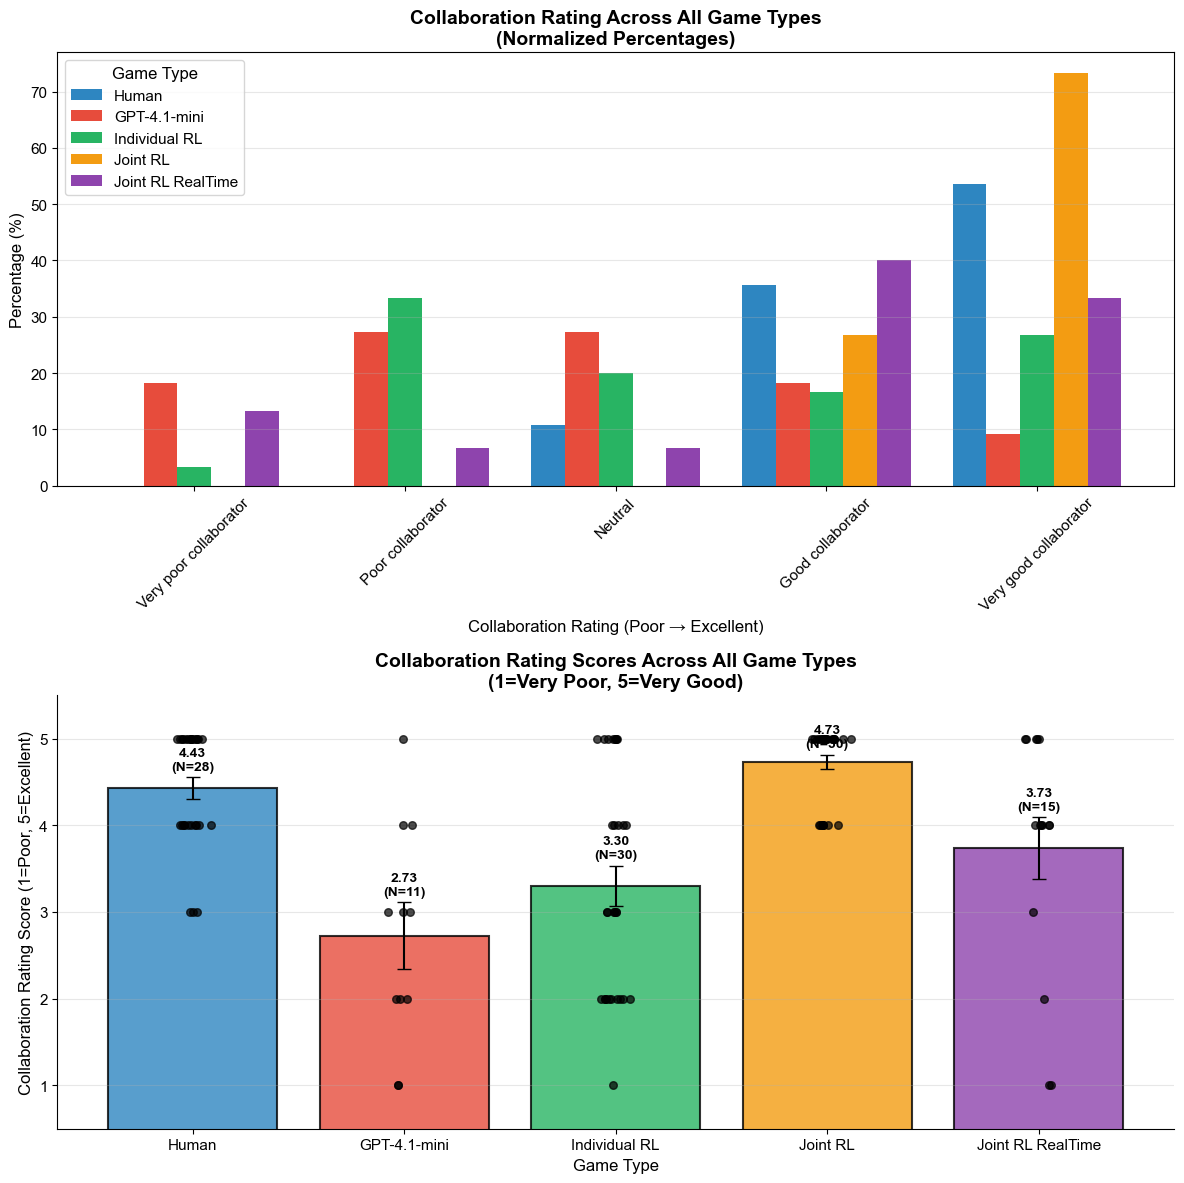

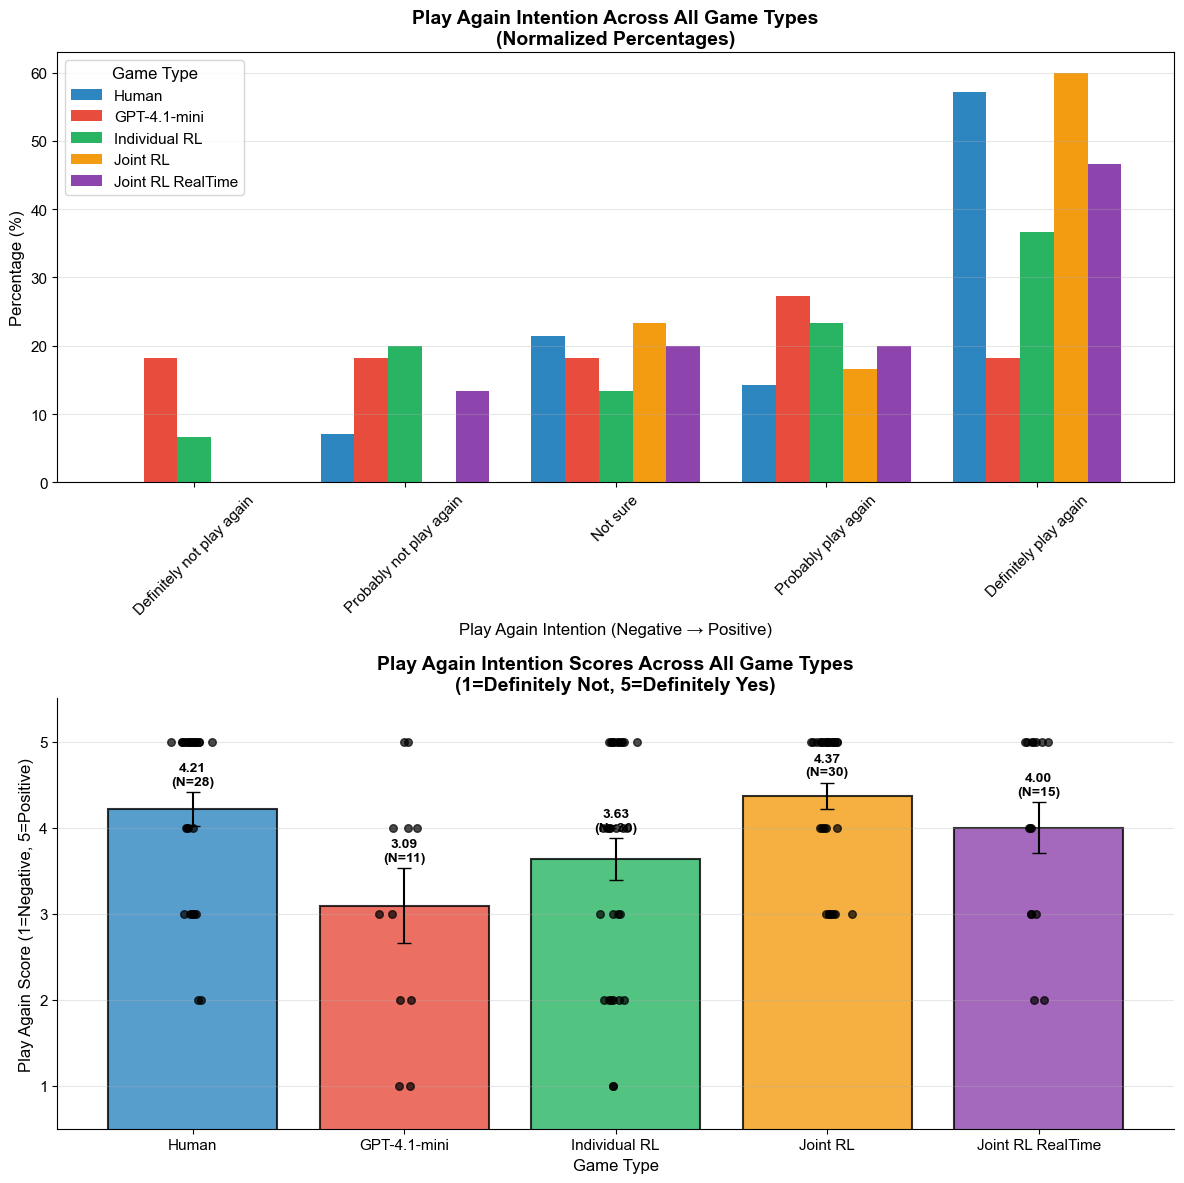

✅ Questionnaire analysis complete


In [295]:
# Figures 5-7: AI Detection, Collaboration Rating, Play Again Analysis
if not data['questionnaire'].empty:
    print("=== COMPREHENSIVE QUESTIONNAIRE ANALYSIS ===")

    # Define ordinal mappings from TimelineManager.js
    ai_detection_order = ['Definitely a person', 'Probably a person', 'Not sure', 'Probably an AI', 'Definitely an AI']
    collaboration_order = ['Very poor collaborator', 'Poor collaborator', 'Neutral', 'Good collaborator', 'Very good collaborator']
    play_again_order = ['Definitely not play again', 'Probably not play again', 'Not sure', 'Probably play again', 'Definitely play again']

    # Convert to categorical
    quest_data = data['questionnaire'].copy()
    quest_data['ai_detection_cat'] = pd.Categorical(quest_data['ai_detection'], categories=ai_detection_order, ordered=True)
    quest_data['collaboration_rating_cat'] = pd.Categorical(quest_data['collaboration_rating'], categories=collaboration_order, ordered=True)
    quest_data['play_again_cat'] = pd.Categorical(quest_data['play_again'], categories=play_again_order, ordered=True)

    available_types = [gt for gt in game_type_order if gt in quest_data['game_type'].values]
    available_labels = [game_type_labels[game_type_order.index(gt)] for gt in available_types]
    available_colors = [CONDITION_COLORS[gt] for gt in available_types]

    print(f"Questionnaire responses: {len(quest_data)}")
    print(f"Game types: {quest_data['game_type'].value_counts()}")

    # AI Detection Analysis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    ai_data = quest_data.groupby(['game_type', 'ai_detection_cat'], observed=True).size().unstack(fill_value=0)
    ai_data_ordered = ai_data.loc[available_types]
    ai_norm = ai_data_ordered.div(ai_data_ordered.sum(axis=1), axis=0) * 100
    ai_norm_reversed = ai_norm.T.iloc[::-1]
    ai_norm_reversed.plot(kind='bar', ax=ax1, width=0.8, color=available_colors)

    ax1.set_title('AI Detection Across All Game Types\n(Normalized Percentages)', fontweight='bold', fontsize=14)
    ax1.set_xlabel('AI Detection (AI-like → Human-like)', fontsize=12)
    ax1.set_ylabel('Percentage (%)', fontsize=12)
    ax1.legend(available_labels, title='Game Type', title_fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)

    # AI Detection Scores
    ai_detection_score_mapping = {'Definitely an AI': 1, 'Probably an AI': 2, 'Not sure': 3, 'Probably a person': 4, 'Definitely a person': 5}
    quest_data['ai_detection_score'] = quest_data['ai_detection'].map(ai_detection_score_mapping)

    score_data, score_errors = [], []
    for game_type in available_types:
        subset = quest_data[quest_data['game_type'] == game_type]
        scores = subset['ai_detection_score'].dropna()
        score_data.append(scores.mean())
        score_errors.append(scores.std() / np.sqrt(len(scores)))

    bars = ax2.bar(available_labels, score_data, yerr=score_errors, capsize=5,
                   alpha=0.8, color=available_colors, edgecolor='black', linewidth=1.5)

    for i, game_type in enumerate(available_types):
        subset = quest_data[quest_data['game_type'] == game_type]
        scores = subset['ai_detection_score'].dropna()
        x_positions = np.random.normal(i, 0.04, size=len(scores))
        ax2.scatter(x_positions, scores, color='black', alpha=0.7, s=30, zorder=3)

    for i, (bar, mean_val, error_val) in enumerate(zip(bars, score_data, score_errors)):
        n = len(quest_data[quest_data['game_type'] == available_types[i]]['ai_detection_score'].dropna())
        ax2.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.05,
                f'{mean_val:.2f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax2.set_title('AI Detection Scores Across All Game Types\n(1=Definitely AI, 5=Definitely Person)', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Game Type', fontsize=12)
    ax2.set_ylabel('AI Detection Score (1=AI-like, 5=Human-like)', fontsize=12)
    ax2.set_ylim(0.5, 5.5)
    ax2.grid(axis='y', alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('merged_ai_detection_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Collaboration Rating Analysis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    collab_data = quest_data.groupby(['game_type', 'collaboration_rating_cat'], observed=True).size().unstack(fill_value=0)
    collab_data_ordered = collab_data.loc[available_types]
    collab_norm = collab_data_ordered.div(collab_data_ordered.sum(axis=1), axis=0) * 100
    collab_norm.T.plot(kind='bar', ax=ax1, width=0.8, color=available_colors)

    ax1.set_title('Collaboration Rating Across All Game Types\n(Normalized Percentages)', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Collaboration Rating (Poor → Excellent)', fontsize=12)
    ax1.set_ylabel('Percentage (%)', fontsize=12)
    ax1.legend(available_labels, title='Game Type', title_fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)

    # Collaboration Rating Scores
    collab_rating_score_mapping = {'Very poor collaborator': 1, 'Poor collaborator': 2, 'Neutral': 3, 'Good collaborator': 4, 'Very good collaborator': 5}
    quest_data['collaboration_rating_score'] = quest_data['collaboration_rating'].map(collab_rating_score_mapping)

    score_data, score_errors = [], []
    for game_type in available_types:
        subset = quest_data[quest_data['game_type'] == game_type]
        scores = subset['collaboration_rating_score'].dropna()
        score_data.append(scores.mean())
        score_errors.append(scores.std() / np.sqrt(len(scores)))

    bars = ax2.bar(available_labels, score_data, yerr=score_errors, capsize=5,
                   alpha=0.8, color=available_colors, edgecolor='black', linewidth=1.5)

    for i, game_type in enumerate(available_types):
        subset = quest_data[quest_data['game_type'] == game_type]
        scores = subset['collaboration_rating_score'].dropna()
        x_positions = np.random.normal(i, 0.04, size=len(scores))
        ax2.scatter(x_positions, scores, color='black', alpha=0.7, s=30, zorder=3)

    for i, (bar, mean_val, error_val) in enumerate(zip(bars, score_data, score_errors)):
        n = len(quest_data[quest_data['game_type'] == available_types[i]]['collaboration_rating_score'].dropna())
        ax2.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.05,
                f'{mean_val:.2f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax2.set_title('Collaboration Rating Scores Across All Game Types\n(1=Very Poor, 5=Very Good)', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Game Type', fontsize=12)
    ax2.set_ylabel('Collaboration Rating Score (1=Poor, 5=Excellent)', fontsize=12)
    ax2.set_ylim(0.5, 5.5)
    ax2.grid(axis='y', alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('merged_collaboration_rating_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Play Again Analysis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    play_data = quest_data.groupby(['game_type', 'play_again_cat'], observed=True).size().unstack(fill_value=0)
    play_data_ordered = play_data.loc[available_types]
    play_norm = play_data_ordered.div(play_data_ordered.sum(axis=1), axis=0) * 100
    play_norm.T.plot(kind='bar', ax=ax1, width=0.8, color=available_colors)

    ax1.set_title('Play Again Intention Across All Game Types\n(Normalized Percentages)', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Play Again Intention (Negative → Positive)', fontsize=12)
    ax1.set_ylabel('Percentage (%)', fontsize=12)
    ax1.legend(available_labels, title='Game Type', title_fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)

    # Play Again Scores
    play_again_score_mapping = {'Definitely not play again': 1, 'Probably not play again': 2, 'Not sure': 3, 'Probably play again': 4, 'Definitely play again': 5}
    quest_data['play_again_score'] = quest_data['play_again'].map(play_again_score_mapping)

    score_data, score_errors = [], []
    for game_type in available_types:
        subset = quest_data[quest_data['game_type'] == game_type]
        scores = subset['play_again_score'].dropna()
        score_data.append(scores.mean())
        score_errors.append(scores.std() / np.sqrt(len(scores)))

    bars = ax2.bar(available_labels, score_data, yerr=score_errors, capsize=5,
                   alpha=0.8, color=available_colors, edgecolor='black', linewidth=1.5)

    for i, game_type in enumerate(available_types):
        subset = quest_data[quest_data['game_type'] == game_type]
        scores = subset['play_again_score'].dropna()
        x_positions = np.random.normal(i, 0.04, size=len(scores))
        ax2.scatter(x_positions, scores, color='black', alpha=0.7, s=30, zorder=3)

    for i, (bar, mean_val, error_val) in enumerate(zip(bars, score_data, score_errors)):
        n = len(quest_data[quest_data['game_type'] == available_types[i]]['play_again_score'].dropna())
        ax2.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.05,
                f'{mean_val:.2f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax2.set_title('Play Again Intention Scores Across All Game Types\n(1=Definitely Not, 5=Definitely Yes)', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Game Type', fontsize=12)
    ax2.set_ylabel('Play Again Score (1=Negative, 5=Positive)', fontsize=12)
    ax2.set_ylim(0.5, 5.5)
    ax2.grid(axis='y', alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('merged_play_again_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Questionnaire analysis complete")

else:
    print("❌ No questionnaire data available")

## 5. Human Commitment Analysis

### 2.6.1 Human Efficiency Across All 5 Game Types


📊 Filtering to trials with new goal presented: 1013 trials


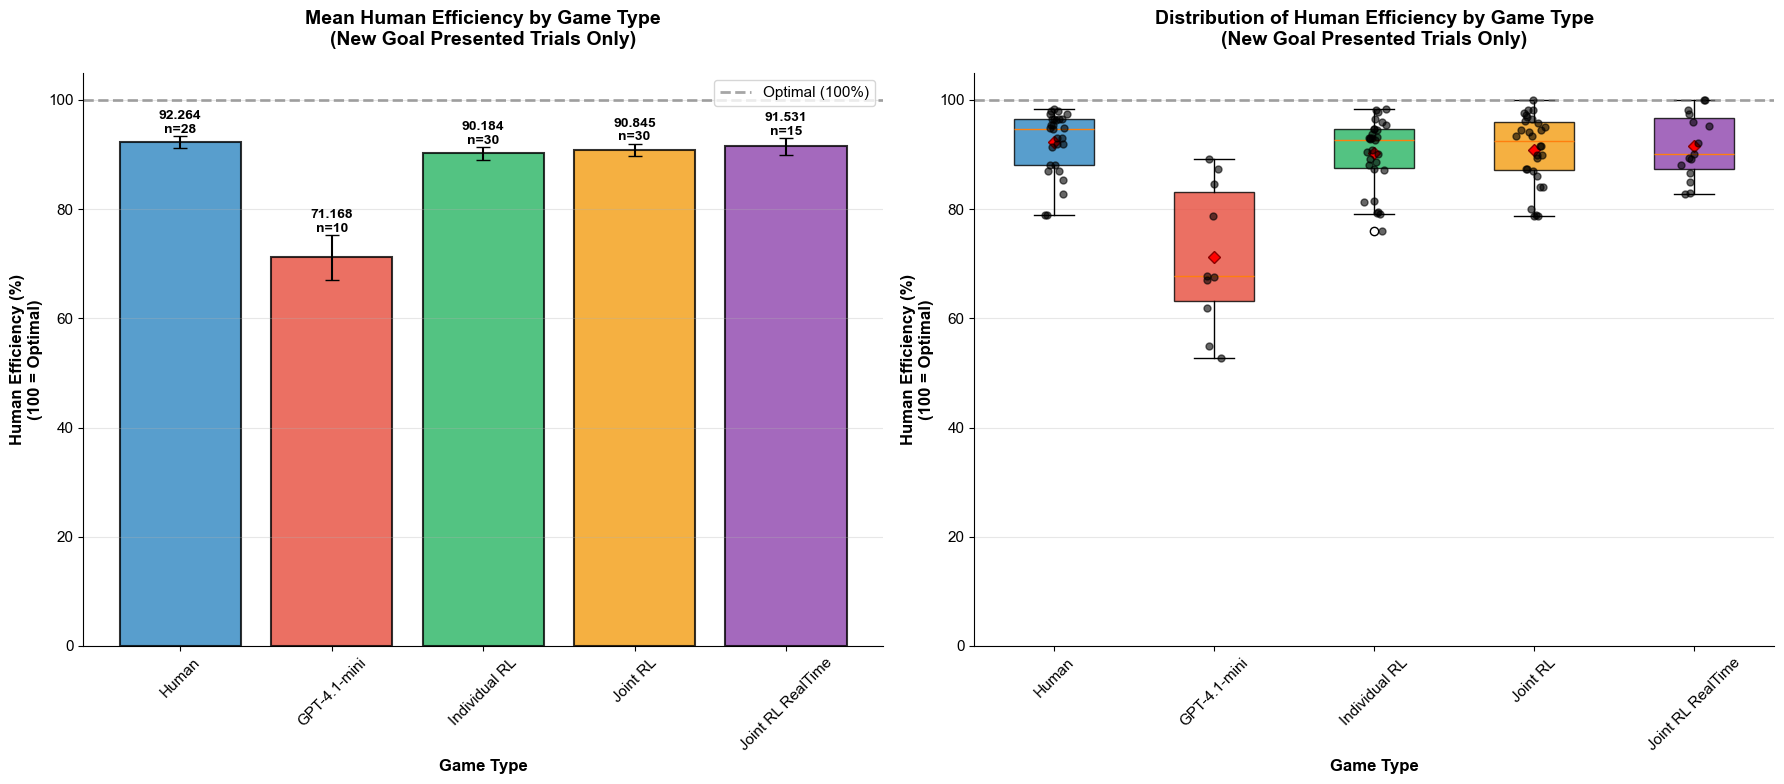


✅ Analysis complete (NEW GOAL TRIALS ONLY): 123 participants across 5 game types

Human: M=92.264, SD=5.663, N=28

GPT-4.1-mini: M=71.168, SD=13.127, N=10

Individual RL: M=90.184, SD=6.274, N=30

Joint RL: M=90.845, SD=6.357, N=30

Joint RL RealTime: M=91.531, SD=5.945, N=15

=== ONE-WAY ANOVA RESULTS (NEW GOAL TRIALS) ===
F-statistic: 19.1354
p-value: 0.0000
✅ Significant difference found between game types (p < 0.05)

=== TUKEY'S HSD POST-HOC ANALYSIS ===
Pairwise comparisons:
Human vs GPT-4.1-mini: p=0.0000 ***, mean_diff=21.097
Human vs Individual RL: p=0.7858 ns, mean_diff=2.080
Human vs Joint RL: p=0.9368 ns, mean_diff=1.420
Human vs Joint RL RealTime: p=0.9974 ns, mean_diff=0.733
GPT-4.1-mini vs Individual RL: p=0.0000 ***, mean_diff=-19.016
GPT-4.1-mini vs Joint RL: p=0.0000 ***, mean_diff=-19.677
GPT-4.1-mini vs Joint RL RealTime: p=0.0000 ***, mean_diff=-20.364
Individual RL vs Joint RL: p=0.9960 ns, mean_diff=-0.661
Individual RL vs Joint RL RealTime: p=0.9728 ns, mean_dif

In [ ]:
# Calculate and visualize human efficiency across all 5 game types
# 1. Define efficiency calculation function
def calculate_human_efficiency_for_row(row):
    """Calculate human efficiency: (actual_steps - optimal_steps) / optimal_steps"""
    try:
        study = row['study']

        # Determine which player is human
        if study == 'Human-RL':
            human_trajs = [row['player1Trajectory']]
        elif study == 'Human-Human-GPT':
            # Check if partner is also human (Human-Human game) or AI (Human-GPT game)
            partner_type = row.get('partnerAgentType', '')
            if partner_type == 'human':
                # Both players are human, analyze both trajectories
                human_trajs = [row['player1Trajectory'], row['player2Trajectory']]
            else:
                # Only one player is human (the other is GPT)
                human_index = row.get('humanPlayerIndex', 0)
                human_trajs = [row[f'player{int(human_index) + 1}Trajectory']]
        else:
            return np.nan

        # Calculate efficiency for each human trajectory
        efficiencies = []
        for human_traj in human_trajs:
            # Parse trajectory
            if isinstance(human_traj, str):
                try:
                    human_traj = ast.literal_eval(human_traj)
                except:
                    continue

            if not human_traj or len(human_traj) < 2:
                continue

            # Calculate actual and optimal steps
            start_pos, final_pos = human_traj[0], human_traj[-1]
            actual_steps = len(human_traj) - 1
            optimal_steps = abs(final_pos[0] - start_pos[0]) + abs(final_pos[1] - start_pos[1])

            if optimal_steps == 0:
                continue

            # efficiencies.append((actual_steps - optimal_steps) / optimal_steps)

            # Calculate efficiency using excess steps logic
            # Normalize to 0-100 scale where 100 = most efficient (optimal)
            excess_steps = actual_steps - optimal_steps
            efficiency_percent = (1 - excess_steps / actual_steps) * 100
            efficiencies.append(efficiency_percent)

        # Return average efficiency across all human players
        return np.mean(efficiencies) if efficiencies else np.nan
    except:
        return np.nan

# 2. Calculate/recalculate human_efficiency column
# Always recalculate to ensure we use the latest function logic
data['trial_data']['human_efficiency'] = data['trial_data'].apply(
    calculate_human_efficiency_for_row, axis=1
)

# 3. Prepare data for plotting - FOCUS ON NEW GOAL PRESENTED TRIALS
efficiency_data = data['trial_data'][
    (~pd.isna(data['trial_data']['human_efficiency'])) &
    (data['trial_data']['human_efficiency'].between(0, 100)) &  # 0-100% efficiency scale
    (data['trial_data']['newGoalPresented'] == True)  # Only trials with new goal presented
].copy()

print(f"📊 Filtering to trials with new goal presented: {len(efficiency_data)} trials")

efficiency_data['participant_id'] = efficiency_data.apply(
    lambda row: extract_participant_id(row['file_id'], row['study']), axis=1
)

participant_efficiency = efficiency_data.groupby(
    ['participant_id', 'game_type', 'study']
)['human_efficiency'].agg(['mean', 'count']).reset_index()
participant_efficiency.columns = ['participant_id', 'game_type', 'study', 'efficiency_mean', 'trial_count']


# 4. Get available game types and colors
available_game_types = [gt for gt in game_type_order if gt in participant_efficiency['game_type'].values]
available_labels = [game_type_labels[game_type_order.index(gt)] for gt in available_game_types]
available_colors = [CONDITION_COLORS.get(gt, '#999999') for gt in available_game_types]

# 5. Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Left: Bar plot with error bars
plot_data = [participant_efficiency[participant_efficiency['game_type'] == gt]['efficiency_mean'].mean()
             for gt in available_game_types]
plot_errors = [participant_efficiency[participant_efficiency['game_type'] == gt]['efficiency_mean'].sem()
               for gt in available_game_types]
plot_ns = [len(participant_efficiency[participant_efficiency['game_type'] == gt])
           for gt in available_game_types]

bars = ax1.bar(available_labels, plot_data, yerr=plot_errors, color=available_colors,
               alpha=0.8, capsize=5, edgecolor='black', linewidth=1.5)

# Add values on bars
for bar, mean, sem, n in zip(bars, plot_data, plot_errors, plot_ns):
    y_pos = mean + sem + 0.02 if mean >= 0 else mean - sem - 0.05
    ax1.text(bar.get_x() + bar.get_width()/2., y_pos, f'{mean:.3f}\nn={n}',
             ha='center', va='bottom' if mean >= 0 else 'top', fontweight='bold', fontsize=10)

ax1.set_title('Mean Human Efficiency by Game Type\n(New Goal Presented Trials Only)', fontweight='bold', fontsize=14, pad=20)
ax1.set_ylabel('Human Efficiency (%)\n(100 = Optimal)', fontweight='bold', fontsize=12)
ax1.set_xlabel('Game Type', fontweight='bold', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.axhline(y=100, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Optimal (100%)')
ax1.set_ylim(0, 105)  # Set y-axis limits for percentage scale
ax1.grid(True, alpha=0.3, axis='y')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend()

# Right: Box plot with individual points
box_data = [participant_efficiency[participant_efficiency['game_type'] == gt]['efficiency_mean'].values
            for gt in available_game_types]
bp = ax2.boxplot(box_data, labels=available_labels, patch_artist=True, showmeans=True,
                 meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

for patch, color in zip(bp['boxes'], available_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)

for i, gt in enumerate(available_game_types):
    game_data = participant_efficiency[participant_efficiency['game_type'] == gt]['efficiency_mean']
    x_positions = np.random.normal(i+1, 0.04, size=len(game_data))
    ax2.scatter(x_positions, game_data, color='black', alpha=0.6, s=25, zorder=3)

ax2.set_title('Distribution of Human Efficiency by Game Type\n(New Goal Presented Trials Only)', fontweight='bold', fontsize=14, pad=20)
ax2.set_ylabel('Human Efficiency (%)\n(100 = Optimal)', fontweight='bold', fontsize=12)
ax2.set_xlabel('Game Type', fontweight='bold', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=100, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Optimal (100%)')
ax2.set_ylim(0, 105)  # Set y-axis limits for percentage scale
ax2.grid(True, alpha=0.3, axis='y')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('human_efficiency_across_5_game_types_new_goal_trials.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Statistical Analysis - ANOVA and Post-hoc tests
print(f"\n✅ Analysis complete (NEW GOAL TRIALS ONLY): {len(participant_efficiency)} participants across {len(available_game_types)} game types")

# Prepare data for ANOVA
efficiency_groups = []
efficiency_labels = []
for gt in available_game_types:
    data_gt = participant_efficiency[participant_efficiency['game_type'] == gt]['efficiency_mean']
    efficiency_groups.append(data_gt.values)
    efficiency_labels.extend([gt] * len(data_gt))
    print(f"\n{game_type_labels[game_type_order.index(gt)]}: M={data_gt.mean():.3f}, SD={data_gt.std():.3f}, N={len(data_gt)}")

# Perform one-way ANOVA
if len(available_game_types) > 1:
    from scipy import stats
    f_stat, p_value = stats.f_oneway(*efficiency_groups)

    print(f"\n=== ONE-WAY ANOVA RESULTS (NEW GOAL TRIALS) ===")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {p_value:.4f}")

    if p_value < 0.05:
        print("✅ Significant difference found between game types (p < 0.05)")

        # Post-hoc analysis using Tukey's HSD
        try:
            from scipy.stats import tukey_hsd

            # Perform Tukey's HSD test
            tukey_result = tukey_hsd(*efficiency_groups)

            print(f"\n=== TUKEY'S HSD POST-HOC ANALYSIS ===")
            print("Pairwise comparisons:")

            for i in range(len(available_game_types)):
                for j in range(i+1, len(available_game_types)):
                    pvalue = tukey_result.pvalue[i, j]
                    mean_diff = np.mean(efficiency_groups[i]) - np.mean(efficiency_groups[j])
                    label_i = game_type_labels[game_type_order.index(available_game_types[i])]
                    label_j = game_type_labels[game_type_order.index(available_game_types[j])]

                    significance = "***" if pvalue < 0.001 else "**" if pvalue < 0.01 else "*" if pvalue < 0.05 else "ns"
                    print(f"{label_i} vs {label_j}: p={pvalue:.4f} {significance}, mean_diff={mean_diff:.3f}")

        except ImportError:
            print("Tukey's HSD not available, performing pairwise t-tests with Bonferroni correction")

            # Alternative: pairwise t-tests with Bonferroni correction
            from scipy.stats import ttest_ind

            n_comparisons = len(available_game_types) * (len(available_game_types) - 1) // 2
            alpha_corrected = 0.05 / n_comparisons

            print(f"\n=== PAIRWISE T-TESTS (Bonferroni corrected α = {alpha_corrected:.4f}) ===")

            for i in range(len(available_game_types)):
                for j in range(i+1, len(available_game_types)):
                    t_stat, p_val = ttest_ind(efficiency_groups[i], efficiency_groups[j])
                    mean_diff = np.mean(efficiency_groups[i]) - np.mean(efficiency_groups[j])
                    label_i = game_type_labels[game_type_order.index(available_game_types[i])]
                    label_j = game_type_labels[game_type_order.index(available_game_types[j])]

                    significance = "*" if p_val < alpha_corrected else "ns"
                    print(f"{label_i} vs {label_j}: t={t_stat:.3f}, p={p_val:.4f} {significance}, mean_diff={mean_diff:.3f}")
    else:
        print("❌ No significant difference found between game types (p ≥ 0.05)")
else:
    print("⚠️ Only one game type available, skipping statistical tests")


# Statistical analysis of efficiency differences between game types
if len(available_game_types) > 1:
    print("\n=== STATISTICAL ANALYSIS: HUMAN VS JOINT RL EFFICIENCY (NEW GOAL TRIALS) ===")

    # Check if we have both Human and Joint RL data
    human_data = participant_efficiency[participant_efficiency['game_type'] == 'human']['efficiency_mean']
    joint_rl_data = participant_efficiency[participant_efficiency['game_type'] == 'joint_rl']['efficiency_mean']

    if len(human_data) > 0 and len(joint_rl_data) > 0:
        from scipy.stats import ttest_ind

        # Perform independent t-test
        t_stat, p_value = ttest_ind(human_data, joint_rl_data)

        # Calculate descriptive statistics
        human_mean = human_data.mean()
        human_std = human_data.std()
        joint_rl_mean = joint_rl_data.mean()
        joint_rl_std = joint_rl_data.std()
        mean_diff = human_mean - joint_rl_mean

        print(f"Human efficiency: {human_mean:.3f} ± {human_std:.3f} (N={len(human_data)})")
        print(f"Joint RL efficiency: {joint_rl_mean:.3f} ± {joint_rl_std:.3f} (N={len(joint_rl_data)})")
        print(f"Mean difference (Human - Joint RL): {mean_diff:.3f}")
        print(f"t-statistic: {t_stat:.3f}")
        print(f"p-value: {p_value:.4f}")

        if p_value < 0.05:
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*"
            print(f"✅ Significant difference found {significance} (p < 0.05)")
        else:
            print("❌ No significant difference found (p ≥ 0.05)")
    else:
        print("⚠️ Insufficient data for Human vs Joint RL comparison")
        if len(human_data) == 0:
            print("   - No Human data available")
        if len(joint_rl_data) == 0:
            print("   - No Joint RL data available")
else:
    print("⚠️ Only one game type available, skipping statistical tests")


=== HUMAN COMMITMENT ANALYSIS ===


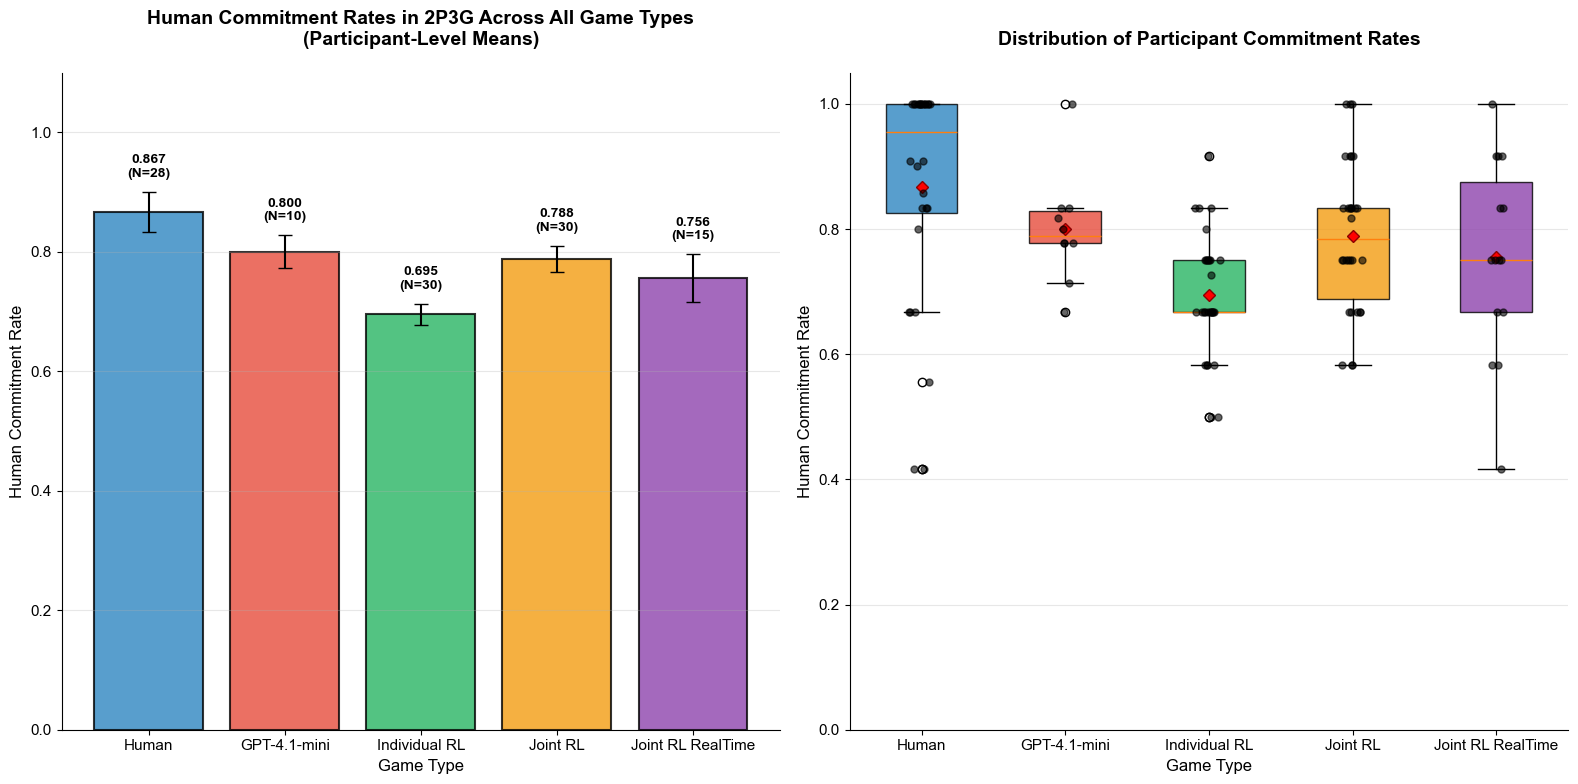

✅ Human commitment analysis complete with 123 participants


In [314]:
# Figure 8: Human Commitment Analysis (merged_commitment_analysis_2p3g.png)
if not data['trial_data'].empty:
    print("=== HUMAN COMMITMENT ANALYSIS ===")

    # Filter commitment data
    commitment_data = data['trial_data'][~pd.isna(data['trial_data']['human_commitment'])].copy()

    if not commitment_data.empty:
        commitment_data['participant_id'] = commitment_data.apply(
            lambda row: extract_participant_id(row['file_id'], row['study']), axis=1
        )

        # Calculate participant-level commitment rates
        participant_commitment = commitment_data.groupby(['participant_id', 'game_type', 'study'])['human_commitment'].mean().reset_index()
        participant_commitment['commitment_rate'] = participant_commitment['human_commitment']

        available_commitment_types = [gt for gt in game_type_order if gt in participant_commitment['game_type'].values]
        available_commitment_labels = [game_type_labels[game_type_order.index(gt)] for gt in available_commitment_types]
        available_commitment_colors = [CONDITION_COLORS[gt] for gt in available_commitment_types]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

        # Bar plot
        plot_data, plot_errors, plot_ns = [], [], []

        for game_type in available_commitment_types:
            participant_data = participant_commitment[participant_commitment['game_type'] == game_type]['commitment_rate']
            plot_data.append(participant_data.mean())
            plot_errors.append(participant_data.std() / np.sqrt(len(participant_data)))
            plot_ns.append(len(participant_data))

        bars = ax1.bar(available_commitment_labels, plot_data, yerr=plot_errors, capsize=5,
                       alpha=0.8, color=available_commitment_colors, edgecolor='black', linewidth=1.5)

        for bar, mean_val, error_val, n in zip(bars, plot_data, plot_errors, plot_ns):
            ax1.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.02,
                    f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

        ax1.set_title('Human Commitment Rates in 2P3G Across All Game Types\n(Participant-Level Means)', fontweight='bold', pad=20)
        ax1.set_ylabel('Human Commitment Rate')
        ax1.set_xlabel('Game Type')
        ax1.set_ylim(0, 1.1)
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)

        # Box plot
        box_data = [participant_commitment[participant_commitment['game_type'] == gt]['commitment_rate'].values
                    for gt in available_commitment_types]

        bp = ax2.boxplot(box_data, labels=available_commitment_labels, patch_artist=True,
                         showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

        for patch, color in zip(bp['boxes'], available_commitment_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.8)

        for i, game_type in enumerate(available_commitment_types):
            participant_data = participant_commitment[participant_commitment['game_type'] == game_type]['commitment_rate']
            x_positions = np.random.normal(i+1, 0.04, size=len(participant_data))
            ax2.scatter(x_positions, participant_data, color='black', alpha=0.6, s=25, zorder=3)

        ax2.set_title('Distribution of Participant Commitment Rates', fontweight='bold', pad=20)
        ax2.set_ylabel('Human Commitment Rate')
        ax2.set_xlabel('Game Type')
        ax2.set_ylim(0, 1.05)
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)

        plt.tight_layout()
        plt.savefig('merged_commitment_analysis_2p3g.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"✅ Human commitment analysis complete with {len(participant_commitment)} participants")
    else:
        print("❌ No commitment data available")
else:
    print("❌ No trial data available for commitment analysis")

### 2.6.2 Human Efficiency: Closer-to-Self vs Closer-to-Other Analysis


=== HUMAN COMMITMENT ANALYSIS - CLOSER CONDITIONS ONLY ===


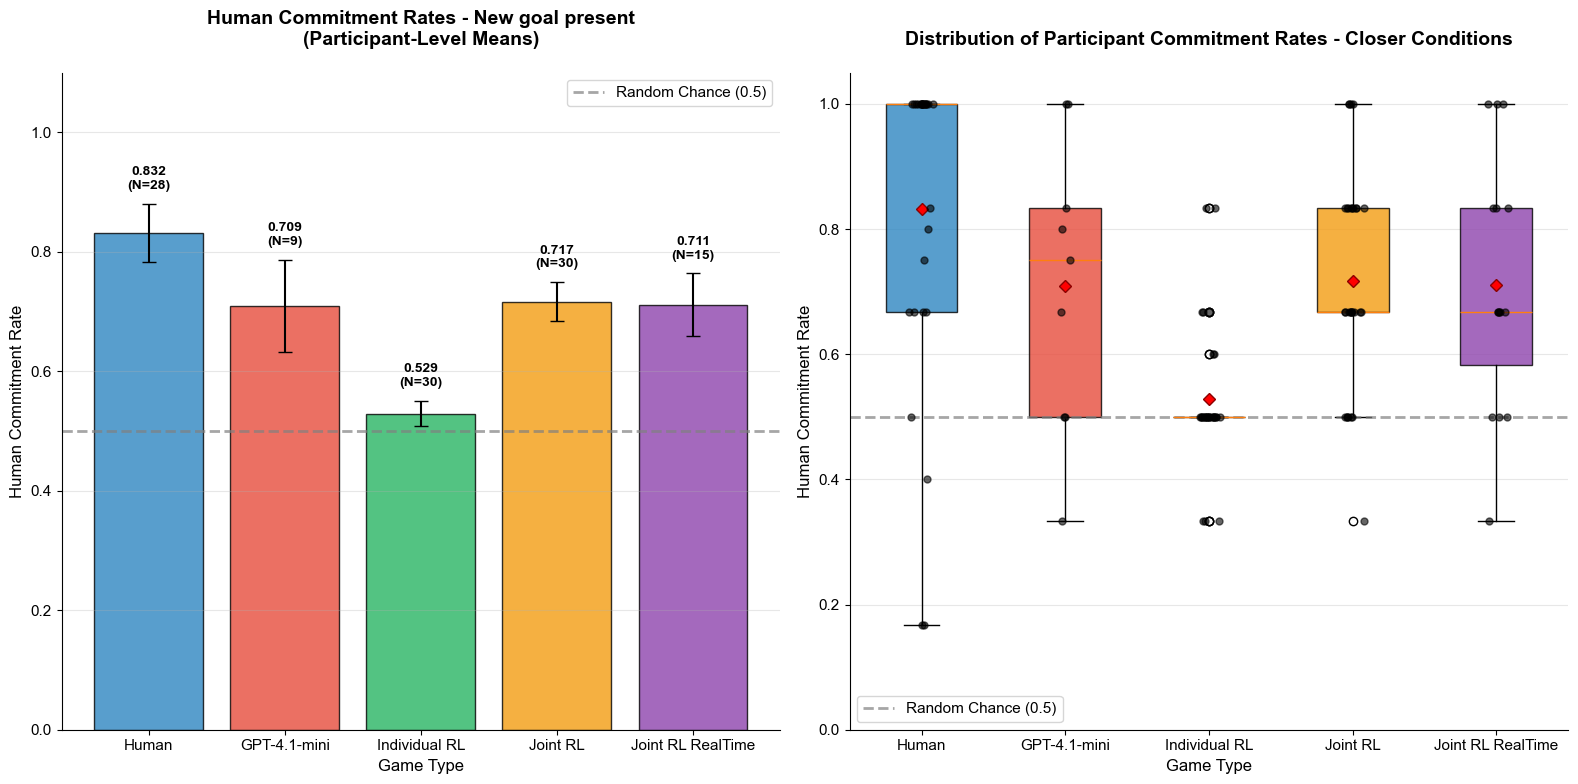

✅ Human commitment analysis (new goal conditions) complete with 122 participants
Total trials analyzed: 675


In [328]:
# Figure 8.5: Human Commitment Analysis - Closer Conditions Only (merged_commitment_closer_conditions_2p3g.png)
if not data['trial_data'].empty:
    print("=== HUMAN COMMITMENT ANALYSIS - CLOSER CONDITIONS ONLY ===")

    # Filter for closer conditions only
    closer_data = data['trial_data'][
        (~pd.isna(data['trial_data']['human_commitment'])) &
        (data['trial_data']['distanceCondition'].isin(['closer_to_player1', 'closer_to_player2']))
    ].copy()

    if not closer_data.empty:
        closer_data['participant_id'] = closer_data.apply(
            lambda row: extract_participant_id(row['file_id'], row['study']), axis=1
        )

        # Create participant-level commitment means for closer conditions
        participant_closer_commitment = closer_data.groupby(
            ['participant_id', 'game_type', 'study']
        )['human_commitment'].mean().reset_index()
        participant_closer_commitment['commitment_rate'] = participant_closer_commitment['human_commitment']

        available_commitment_types = [gt for gt in game_type_order if gt in participant_closer_commitment['game_type'].values]
        available_commitment_labels = [game_type_labels[game_type_order.index(gt)] for gt in available_commitment_types]
        available_commitment_colors = [CONDITION_COLORS[gt] for gt in available_commitment_types]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

        # Bar plot
        plot_data, plot_errors, plot_ns = [], [], []

        for game_type in available_commitment_types:
            game_data = participant_closer_commitment[participant_closer_commitment['game_type'] == game_type]['commitment_rate']
            if len(game_data) > 0:
                plot_data.append(game_data.mean())
                plot_errors.append(game_data.sem())
                plot_ns.append(len(game_data))
            else:
                plot_data.append(0)
                plot_errors.append(0)
                plot_ns.append(0)

        bars = ax1.bar(available_commitment_labels, plot_data, yerr=plot_errors,
                      capsize=5, color=available_commitment_colors, alpha=0.8, edgecolor='black', linewidth=1)

        # Add random chance baseline
        ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Random Chance (0.5)')

        for bar, mean_val, error_val, n in zip(bars, plot_data, plot_errors, plot_ns):
            ax1.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.02,
                    f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

        ax1.set_title('Human Commitment Rates - New goal present\n(Participant-Level Means)', fontweight='bold', pad=20)
        ax1.set_ylabel('Human Commitment Rate')
        ax1.set_xlabel('Game Type')
        ax1.set_ylim(0, 1.1)
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.legend()

        # Box plot
        box_data = [participant_closer_commitment[participant_closer_commitment['game_type'] == gt]['commitment_rate'].values
                    for gt in available_commitment_types]

        bp = ax2.boxplot(box_data, labels=available_commitment_labels, patch_artist=True,
                         showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

        # Add random chance baseline
        ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Random Chance (0.5)')

        for patch, color in zip(bp['boxes'], available_commitment_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.8)

        for i, game_type in enumerate(available_commitment_types):
            participant_data = participant_closer_commitment[participant_closer_commitment['game_type'] == game_type]['commitment_rate']
            x_positions = np.random.normal(i+1, 0.04, size=len(participant_data))
            ax2.scatter(x_positions, participant_data, color='black', alpha=0.6, s=25, zorder=3)

        ax2.set_title('Distribution of Participant Commitment Rates - Closer Conditions', fontweight='bold', pad=20)
        ax2.set_ylabel('Human Commitment Rate')
        ax2.set_xlabel('Game Type')
        ax2.set_ylim(0, 1.05)
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.legend()

        plt.tight_layout()
        plt.savefig('merged_commitment_closer_conditions_2p3g.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"✅ Human commitment analysis (new goal conditions) complete with {len(participant_closer_commitment)} participants")
        print(f"Total trials analyzed: {len(closer_data)}")
    else:
        print("❌ No commitment data available for closer conditions")
else:
    print("❌ No trial data available for commitment analysis")


### test Efficiency ~ Commitment 

=== REGRESSION ANALYSIS: EFFICIENCY vs COMMITMENT ===
Available game types: ['joint-rl-realTime' 'individual_rl' 'joint_rl' 'human' 'gpt-4.1-mini'
 'mixed']
Target conditions for analysis: ['human', 'joint_rl', 'individual_rl', 'joint-rl-realTime', 'gpt-4.1-mini']


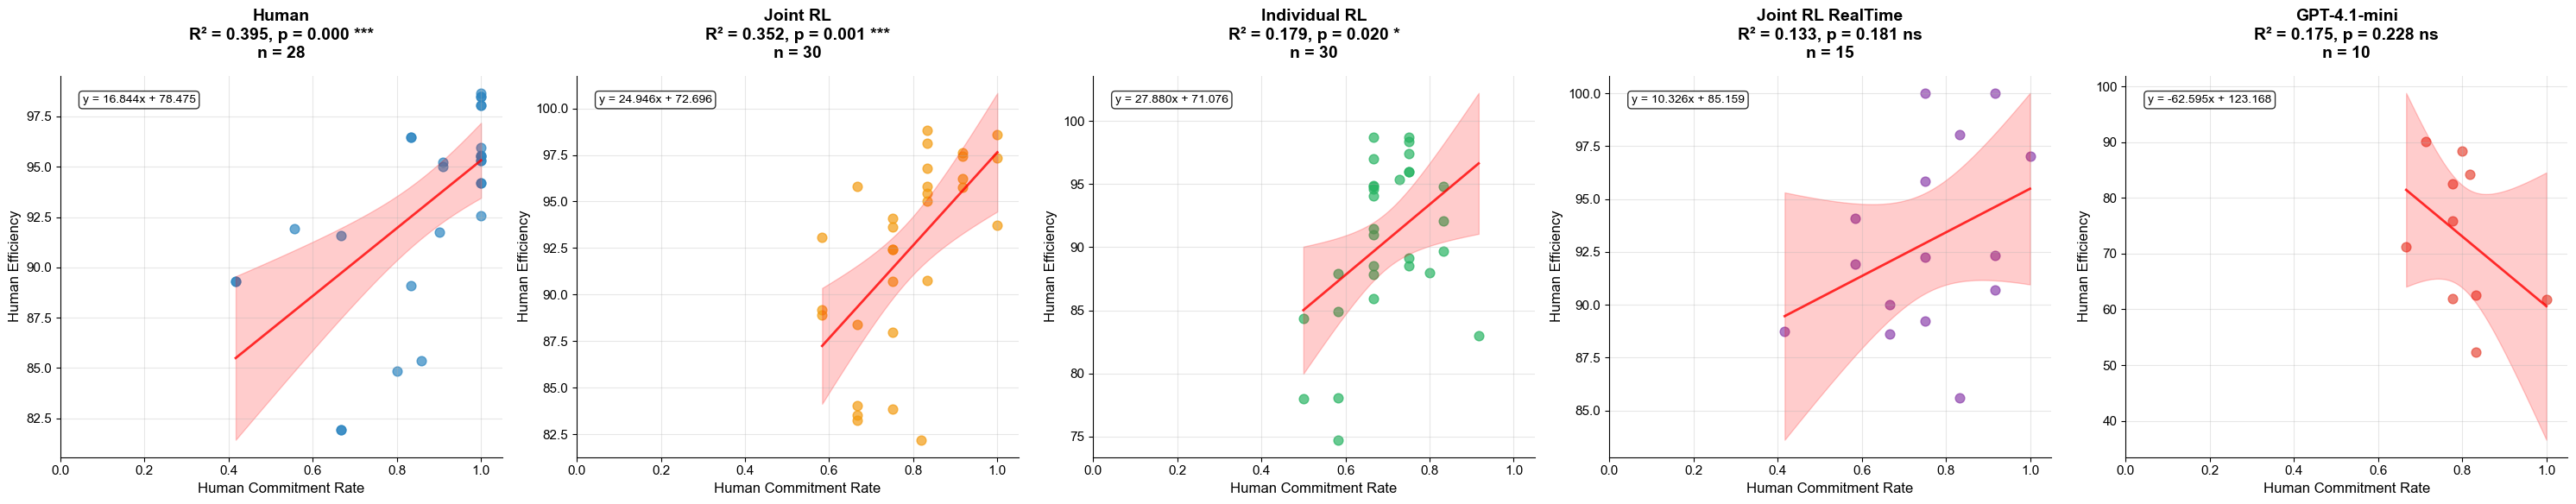


📊 REGRESSION RESULTS (Human Efficiency vs Commitment):

Human:
  Slope: 16.8445 ± 4.0870
  R²: 0.3952
  p-value: 0.0003 ***
  Sample size: 28
  → Significant positive relationship between commitment and human efficiency

Joint RL:
  Slope: 24.9457 ± 6.3977
  R²: 0.3519
  p-value: 0.0006 ***
  Sample size: 30
  → Significant positive relationship between commitment and human efficiency

Individual RL:
  Slope: 27.8803 ± 11.2946
  R²: 0.1787
  p-value: 0.0199 *
  Sample size: 30
  → Significant positive relationship between commitment and human efficiency

Joint RL RealTime:
  Slope: 10.3262 ± 7.2991
  R²: 0.1334
  p-value: 0.1807 ns
  Sample size: 15
  → No significant relationship found

GPT-4.1-mini:
  Slope: -62.5946 ± 47.9874
  R²: 0.1754
  p-value: 0.2284 ns
  Sample size: 10
  → No significant relationship found

🔍 CONDITION-SPECIFIC CORRELATIONS:

Human:
  Pearson r: 0.6286
  p-value: 0.0003 ***
  Sample size: 28

Joint RL:
  Pearson r: 0.5932
  p-value: 0.0006 ***
  Sample size

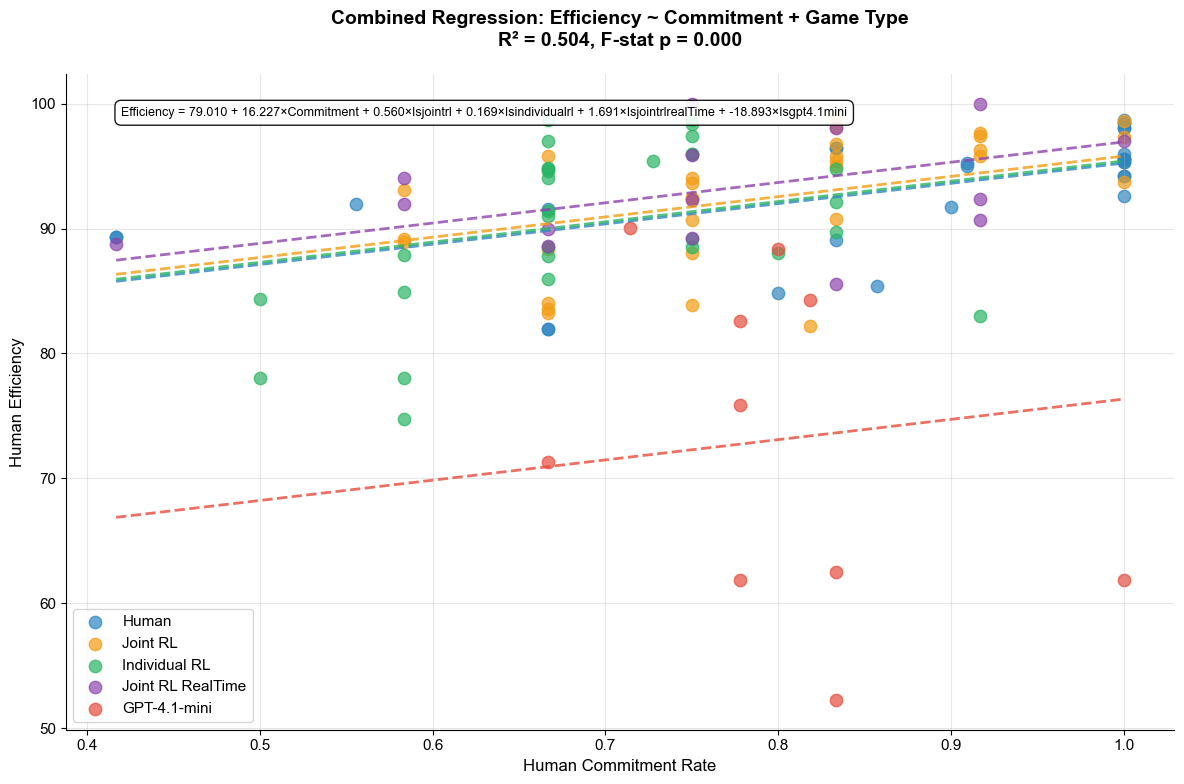


📊 COMBINED REGRESSION RESULTS:
Model: Efficiency ~ Commitment + Game_Type
R²: 0.5038
Adjusted R²: 0.4806
F-statistic: 21.7287
F-statistic p-value: 0.0000
Sample size: 113

Coefficients:
  const: 79.0103 (p = 0.0000) ***
  human_commitment: 16.2270 (p = 0.0002) ***
  is_joint_rl: 0.5598 (p = 0.7296) ns
  is_individual_rl: 0.1686 (p = 0.9230) ns
  is_joint-rl-realTime: 1.6908 (p = 0.3956) ns
  is_gpt-4.1-mini: -18.8930 (p = 0.0000) ***

Interpretation:
  • Commitment significantly increases efficiency (β = 16.2270)
  • No significant difference in efficiency between Joint Rl and Human conditions
  • No significant difference in efficiency between Individual Rl and Human conditions
  • No significant difference in efficiency between Joint-Rl-Realtime and Human conditions
  • Gpt-4.1-Mini condition shows significantly lower efficiency than Human condition (β = -18.8930)


In [331]:
# Figure 8.5: Regression Analysis - Efficiency vs Commitment
if not data['trial_data'].empty:
    print("=== REGRESSION ANALYSIS: EFFICIENCY vs COMMITMENT ===")


    data['trial_data']['human_efficiency'] = data['trial_data']['human_efficiency'].replace([np.inf, -np.inf], np.nan)
    # Filter data for regression analysis
    regression_data = data['trial_data'][
        (~pd.isna(data['trial_data']['human_commitment'])) &
        (~pd.isna(data['trial_data']['human_efficiency'])) &
        (data['trial_data']['human_efficiency'] > 0)  # Valid efficiency values
    ].copy()

    if not regression_data.empty:
        regression_data['participant_id'] = regression_data.apply(
            lambda row: extract_participant_id(row['file_id'], row['study']), axis=1
        )

        # Create participant-level aggregated data
        participant_regression = regression_data.groupby(
            ['participant_id', 'game_type', 'study']
        ).agg({
            'human_commitment': 'mean',
            'human_efficiency': 'mean'
        }).reset_index()

        # Perform regression analysis for human and AI conditions separately
        from scipy import stats
        import seaborn as sns

        # Check what game types are actually available
        available_game_types = participant_regression['game_type'].unique()
        print(f"Available game types: {available_game_types}")

        # Filter for human and AI conditions (expanded to include more AI types)
        target_conditions = []
        target_labels = []
        target_colors = []

        if 'human' in available_game_types:
            target_conditions.append('human')
            target_labels.append(game_type_labels[game_type_order.index('human')])
            target_colors.append(game_type_colors[game_type_order.index('human')])

        # Check for all AI conditions
        ai_conditions = ['joint_rl', 'individual_rl', 'joint-rl-realTime', 'gpt-4.1-mini']
        for condition in ai_conditions:
            if condition in available_game_types:
                target_conditions.append(condition)
                # Try to find the label, fallback to the condition name
                try:
                    ai_idx = game_type_order.index(condition)
                    target_labels.append(game_type_labels[ai_idx])
                    target_colors.append(game_type_colors[ai_idx])
                except ValueError:
                    target_labels.append(condition.replace('-', ' ').replace('_', ' ').title())
                    # Use different colors for different AI types
                    if 'joint' in condition:
                        target_colors.append('orange')
                    elif 'individual' in condition:
                        target_colors.append('purple')
                    elif 'gpt' in condition:
                        target_colors.append('green')
                    else:
                        target_colors.append('gray')

        print(f"Target conditions for analysis: {target_conditions}")

        if len(target_conditions) == 0:
            print("❌ No human or AI conditions found in data")
        else:
            # Create plots based on available conditions
            fig, axes = plt.subplots(1, len(target_conditions), figsize=(6 * len(target_conditions), 6))
            if len(target_conditions) == 1:
                axes = [axes]

            regression_results = {}

            for i, game_type in enumerate(target_conditions):
                ax = axes[i]
                game_label = target_labels[i]

                game_data = participant_regression[participant_regression['game_type'] == game_type]

                if len(game_data) >= 3:  # Need at least 3 points for regression
                    x = game_data['human_commitment'].values
                    y = game_data['human_efficiency'].values

                    # Perform linear regression
                    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

                    # Store results
                    regression_results[game_type] = {
                        'slope': slope,
                        'intercept': intercept,
                        'r_value': r_value,
                        'r_squared': r_value**2,
                        'p_value': p_value,
                        'std_err': std_err,
                        'n': len(game_data)
                    }

                    # Create scatter plot
                    ax.scatter(x, y, alpha=0.7, s=60, color=target_colors[i])

                    # Add regression line
                    x_line = np.linspace(x.min(), x.max(), 100)
                    y_line = slope * x_line + intercept
                    ax.plot(x_line, y_line, 'r-', alpha=0.8, linewidth=2)

                    # Add confidence interval
                    from scipy.stats import t
                    n = len(x)
                    dof = n - 2
                    t_val = t.ppf(0.975, dof)

                    # Calculate prediction intervals
                    x_mean = np.mean(x)
                    sxx = np.sum((x - x_mean)**2)
                    sxy = np.sum((x - x_mean) * (y - np.mean(y)))
                    syy = np.sum((y - np.mean(y))**2)
                    s_yx = np.sqrt((syy - slope**2 * sxx) / dof)

                    conf_interval = t_val * s_yx * np.sqrt(1/n + (x_line - x_mean)**2 / sxx)
                    ax.fill_between(x_line, y_line - conf_interval, y_line + conf_interval,
                                   alpha=0.2, color='red', label='95% CI')

                    # Format title with statistics
                    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                    ax.set_title(f'{game_label}\nR² = {r_value**2:.3f}, p = {p_value:.3f} {significance}\nn = {n}',
                               fontweight='bold', pad=15)

                    # Add equation text
                    equation_text = f'y = {slope:.3f}x + {intercept:.3f}'
                    ax.text(0.05, 0.95, equation_text, transform=ax.transAxes,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                           verticalalignment='top', fontsize=10)

                else:
                    ax.text(0.5, 0.5, f'Insufficient data\n(n = {len(game_data)})',
                           transform=ax.transAxes, ha='center', va='center', fontsize=12)
                    ax.set_title(f'{game_label}\nInsufficient Data', fontweight='bold', pad=15)

                ax.set_xlabel('Human Commitment Rate')
                ax.set_ylabel('Human Efficiency')
                ax.set_xlim(0, 1.05)
                ax.grid(True, alpha=0.3)
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)

            plt.tight_layout()
            plt.savefig('human_efficiency_commitment_regression_2p3g.png', dpi=300, bbox_inches='tight')
            plt.show()

            # Print regression results
            print("\n📊 REGRESSION RESULTS (Human Efficiency vs Commitment):")
            print("=" * 80)
            for game_type, results in regression_results.items():
                game_label = target_labels[target_conditions.index(game_type)]
                significance = "***" if results['p_value'] < 0.001 else "**" if results['p_value'] < 0.01 else "*" if results['p_value'] < 0.05 else "ns"

                print(f"\n{game_label}:")
                print(f"  Slope: {results['slope']:.4f} ± {results['std_err']:.4f}")
                print(f"  R²: {results['r_squared']:.4f}")
                print(f"  p-value: {results['p_value']:.4f} {significance}")
                print(f"  Sample size: {results['n']}")

                if results['p_value'] < 0.05:
                    direction = "positive" if results['slope'] > 0 else "negative"
                    print(f"  → Significant {direction} relationship between commitment and human efficiency")
                else:
                    print(f"  → No significant relationship found")

            # Separate correlation analysis for available conditions
            print(f"\n🔍 CONDITION-SPECIFIC CORRELATIONS:")
            for i, game_type in enumerate(target_conditions):
                game_label = target_labels[i]
                condition_data = participant_regression[participant_regression['game_type'] == game_type]

                if len(condition_data) >= 3:
                    commitment_vals = condition_data['human_commitment'].values
                    efficiency_vals = condition_data['human_efficiency'].values

                    r, p = stats.pearsonr(commitment_vals, efficiency_vals)
                    significance = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"

                    print(f"\n{game_label}:")
                    print(f"  Pearson r: {r:.4f}")
                    print(f"  p-value: {p:.4f} {significance}")
                    print(f"  Sample size: {len(commitment_vals)}")

            print(f"\n✅ Human efficiency regression analysis complete with {len(participant_regression)} participant observations")

            # NEW: Combined regression analysis with game type as predictor
            print("\n=== COMBINED REGRESSION: EFFICIENCY ~ COMMITMENT + GAME TYPE ===")

            # Prepare data for combined regression
            combined_data = participant_regression[participant_regression['game_type'].isin(target_conditions)].copy()

            if len(combined_data) >= 6:  # Need sufficient data for multiple regression
                # Create dummy variables for game type (using human as reference)
                for condition in target_conditions:
                    if condition != 'human':
                        combined_data[f'is_{condition}'] = (combined_data['game_type'] == condition).astype(int)

                # Perform multiple regression using statsmodels for better statistics
                try:
                    import statsmodels.api as sm

                    # Prepare predictors
                    predictor_cols = ['human_commitment']
                    for condition in target_conditions:
                        if condition != 'human':
                            predictor_cols.append(f'is_{condition}')

                    X = combined_data[predictor_cols].copy()
                    X = sm.add_constant(X)  # Add intercept
                    y = combined_data['human_efficiency']

                    # Fit model
                    model = sm.OLS(y, X).fit()

                    # Create combined regression plot
                    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

                    # Plot data points for each game type
                    for i, game_type in enumerate(target_conditions):
                        game_data = combined_data[combined_data['game_type'] == game_type]
                        ax.scatter(game_data['human_commitment'], game_data['human_efficiency'],
                                 alpha=0.7, s=80, color=target_colors[i], label=target_labels[i])

                    # Plot regression lines for each game type
                    x_range = np.linspace(combined_data['human_commitment'].min(),
                                        combined_data['human_commitment'].max(), 100)

                    for i, game_type in enumerate(target_conditions):
                        if game_type == 'human':
                            # Human condition (reference category)
                            y_pred = model.params['const'] + model.params['human_commitment'] * x_range
                        else:
                            # AI conditions
                            y_pred = (model.params['const'] + model.params['human_commitment'] * x_range +
                                    model.params[f'is_{game_type}'])

                        ax.plot(x_range, y_pred, '--', color=target_colors[i], linewidth=2, alpha=0.8)

                    # Format plot
                    ax.set_xlabel('Human Commitment Rate', fontsize=12)
                    ax.set_ylabel('Human Efficiency', fontsize=12)
                    ax.set_title(f'Combined Regression: Efficiency ~ Commitment + Game Type\n'
                               f'R² = {model.rsquared:.3f}, F-stat p = {model.f_pvalue:.3f}',
                               fontweight='bold', pad=20)
                    ax.legend()
                    ax.grid(True, alpha=0.3)
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)

                    # Add model equation
                    equation_parts = [f'{model.params["const"]:.3f}',
                                    f'{model.params["human_commitment"]:.3f}×Commitment']
                    for condition in target_conditions:
                        if condition != 'human':
                            equation_parts.append(f'{model.params[f"is_{condition}"]:.3f}×Is{condition.replace("_", "").replace("-", "")}')

                    equation_text = f'Efficiency = {" + ".join(equation_parts)}'
                    ax.text(0.05, 0.95, equation_text, transform=ax.transAxes,
                           bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.9),
                           verticalalignment='top', fontsize=9)

                    plt.tight_layout()
                    plt.savefig('combined_efficiency_commitment_regression_2p3g.png', dpi=300, bbox_inches='tight')
                    plt.show()

                    # Print detailed results
                    print("\n📊 COMBINED REGRESSION RESULTS:")
                    print("=" * 60)
                    print(f"Model: Efficiency ~ Commitment + Game_Type")
                    print(f"R²: {model.rsquared:.4f}")
                    print(f"Adjusted R²: {model.rsquared_adj:.4f}")
                    print(f"F-statistic: {model.fvalue:.4f}")
                    print(f"F-statistic p-value: {model.f_pvalue:.4f}")
                    print(f"Sample size: {len(combined_data)}")

                    print("\nCoefficients:")
                    for param_name, coef in model.params.items():
                        p_val = model.pvalues[param_name]
                        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                        print(f"  {param_name}: {coef:.4f} (p = {p_val:.4f}) {significance}")

                    # Interpretation
                    print("\nInterpretation:")
                    commitment_effect = model.params['human_commitment']

                    if model.pvalues['human_commitment'] < 0.05:
                        direction = "increases" if commitment_effect > 0 else "decreases"
                        print(f"  • Commitment significantly {direction} efficiency (β = {commitment_effect:.4f})")
                    else:
                        print(f"  • No significant effect of commitment on efficiency")

                    for condition in target_conditions:
                        if condition != 'human':
                            param_name = f'is_{condition}'
                            if param_name in model.params:
                                game_type_effect = model.params[param_name]
                                if model.pvalues[param_name] < 0.05:
                                    direction = "higher" if game_type_effect > 0 else "lower"
                                    print(f"  • {condition.replace('_', ' ').title()} condition shows significantly {direction} efficiency than Human condition (β = {game_type_effect:.4f})")
                                else:
                                    print(f"  • No significant difference in efficiency between {condition.replace('_', ' ').title()} and Human conditions")

                except ImportError:
                    print("❌ statsmodels not available for combined regression analysis")
                except Exception as e:
                    print(f"❌ Error in combined regression analysis: {e}")
            else:
                print(f"❌ Insufficient data for combined regression (n = {len(combined_data)})")

    else:
        print("❌ No valid data available for regression analysis")
else:
    print("❌ No trial data available for regression analysis")


## 6. Human Commitment by Distance Condition

=== HUMAN COMMITMENT BY DISTANCE CONDITIONS ===


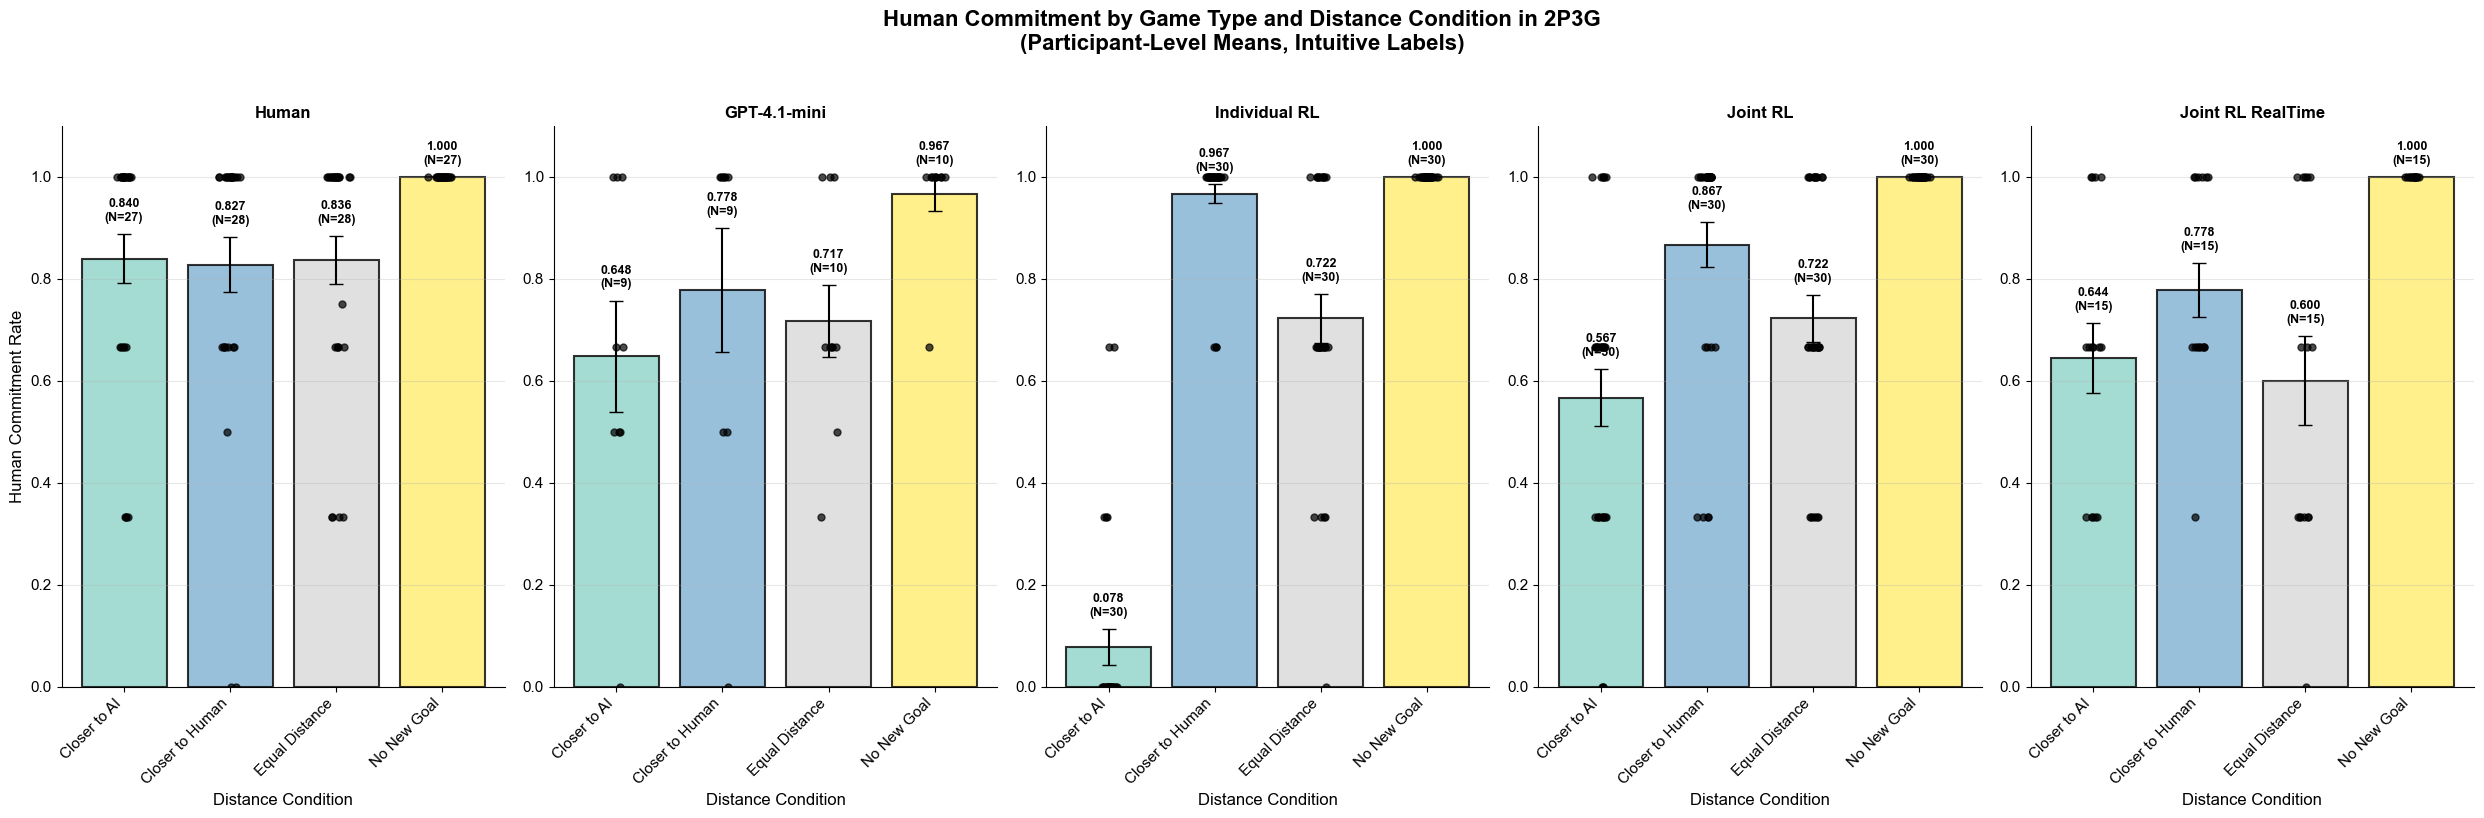

✅ Human commitment by distance analysis complete


In [300]:
# Figure 9: Human Commitment by Distance Condition (merged_commitment_by_distance_condition_2p3g.png)
if not data['trial_data'].empty:
    print("=== HUMAN COMMITMENT BY DISTANCE CONDITIONS ===")

    # Filter commitment data with distance conditions
    commitment_data = data['trial_data'][
        (~pd.isna(data['trial_data']['human_commitment'])) &
        (~pd.isna(data['trial_data']['distanceCondition_renamed']))
    ].copy()

    if not commitment_data.empty:
        commitment_data['participant_id'] = commitment_data.apply(
            lambda row: extract_participant_id(row['file_id'], row['study']), axis=1
        )

        # Create participant-level commitment means by distance condition
        participant_distance_commitment = commitment_data.groupby(
            ['participant_id', 'game_type', 'study', 'distanceCondition_renamed']
        )['human_commitment'].mean().reset_index()
        participant_distance_commitment['commitment_rate'] = participant_distance_commitment['human_commitment']

        distance_conditions = sorted(participant_distance_commitment['distanceCondition_renamed'].unique())
        available_commitment_types = [gt for gt in game_type_order if gt in participant_distance_commitment['game_type'].values]
        available_commitment_labels = [game_type_labels[game_type_order.index(gt)] for gt in available_commitment_types]

        distance_colors = plt.cm.Set3(np.linspace(0, 1, len(distance_conditions)))

        fig, axes = plt.subplots(1, len(available_commitment_types), figsize=(5 * len(available_commitment_types), 8))
        if len(available_commitment_types) == 1:
            axes = [axes]

        for i, game_type in enumerate(available_commitment_types):
            ax = axes[i]
            game_label = available_commitment_labels[i]

            game_data = participant_distance_commitment[participant_distance_commitment['game_type'] == game_type]

            if len(game_data) > 0:
                plot_data, plot_errors, plot_ns, plot_labels, plot_colors = [], [], [], [], []

                for j, distance_condition in enumerate(distance_conditions):
                    distance_game_data = game_data[game_data['distanceCondition_renamed'] == distance_condition]['commitment_rate']
                    if len(distance_game_data) > 0:
                        plot_data.append(distance_game_data.mean())
                        plot_errors.append(distance_game_data.std() / np.sqrt(len(distance_game_data)))
                        plot_ns.append(len(distance_game_data))

                        # Create human-friendly label
                        if distance_condition == 'no_new_goal':
                            label = 'No New Goal'
                        elif distance_condition == 'closer_to_human':
                            label = 'Closer to Human'
                        elif distance_condition == 'closer_to_AI':
                            label = 'Closer to AI'
                        elif distance_condition == 'equal_to_both':
                            label = 'Equal Distance'
                        else:
                            label = str(distance_condition)

                        plot_labels.append(label)
                        plot_colors.append(distance_colors[j])

                if plot_data:
                    bars = ax.bar(range(len(plot_labels)), plot_data, yerr=plot_errors, capsize=5,
                                  alpha=0.8, color=plot_colors, edgecolor='black', linewidth=1.5)

                    ax.set_xticks(range(len(plot_labels)))
                    ax.set_xticklabels(plot_labels, rotation=45, ha='right')

                    # Add individual participant points
                    for j, distance_condition in enumerate(distance_conditions):
                        distance_game_data = game_data[game_data['distanceCondition_renamed'] == distance_condition]['commitment_rate']
                        if len(distance_game_data) > 0:
                            x_positions = np.random.normal(j, 0.04, size=len(distance_game_data))
                            ax.scatter(x_positions, distance_game_data, color='black', alpha=0.7, s=25, zorder=3)

                    # Add value labels
                    for bar, mean_val, error_val, n in zip(bars, plot_data, plot_errors, plot_ns):
                        ax.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.02,
                                f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=9)

            ax.set_title(f'{game_label}', fontweight='bold', fontsize=12)
            ax.set_ylabel('Human Commitment Rate' if i == 0 else '')
            ax.set_xlabel('Distance Condition')
            ax.set_ylim(0, 1.1)
            ax.grid(True, alpha=0.3, axis='y')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        plt.suptitle('Human Commitment by Game Type and Distance Condition in 2P3G\n(Participant-Level Means, Intuitive Labels)',
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.savefig('merged_commitment_by_distance_condition_2p3g.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"✅ Human commitment by distance analysis complete")
    else:
        print("❌ No commitment by distance data available")
else:
    print("❌ No trial data available for commitment by distance analysis")

## 7. AI Commitment by Distance Condition

=== AI COMMITMENT BY DISTANCE CONDITIONS ===


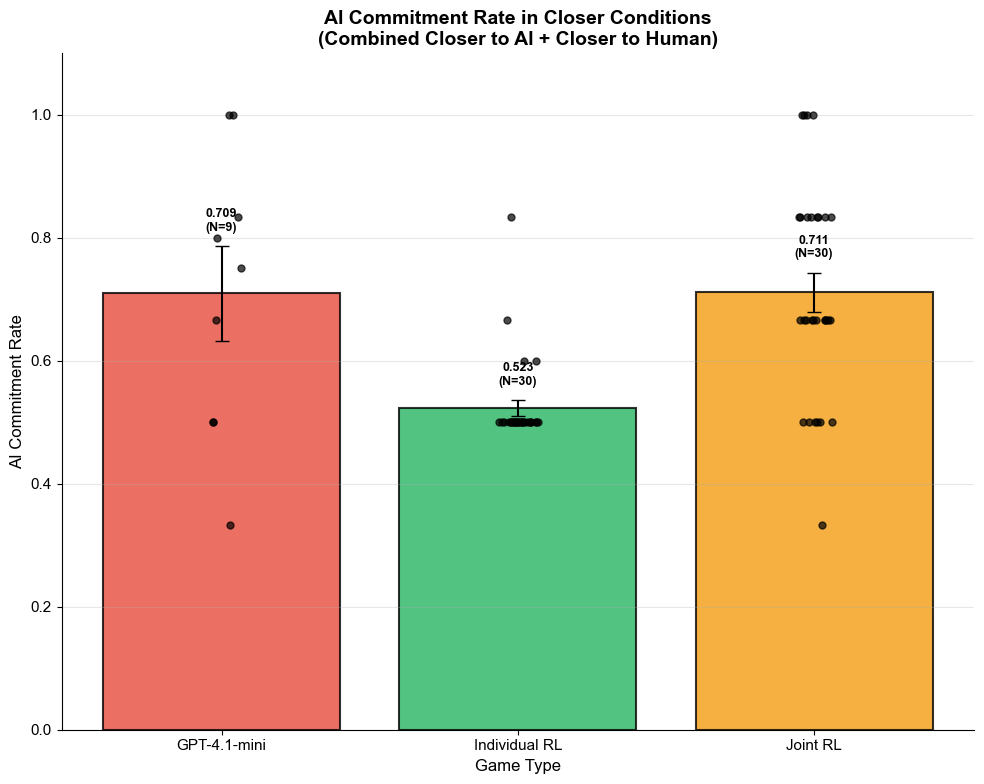

✅ AI commitment by distance analysis complete (closer conditions combined)


In [301]:
# Figure 10: AI Commitment by Distance Condition (merged_ai_commitment_by_distance_condition_2p3g.png)
if not data['trial_data'].empty:
    print("=== AI COMMITMENT BY DISTANCE CONDITIONS ===")

    # Filter to human-AI game types and calculate AI commitment
    human_ai_types = ['gpt-4.1-mini', 'individual_rl', 'joint_rl']
    ai_commitment_data = data['trial_data'][
        (data['trial_data']['game_type'].isin(human_ai_types)) &
        (~pd.isna(data['trial_data']['distanceCondition_renamed']))
    ].copy()

    if not ai_commitment_data.empty:
        # Calculate AI commitment for trials that don't have it yet
        if 'ai_commitment' not in ai_commitment_data.columns or ai_commitment_data['ai_commitment'].isna().any():
            ai_commitment_data['ai_commitment'] = ai_commitment_data.apply(
                lambda row: calculate_ai_commitment_2p3g(
                    row, 'Human-RL' if row['game_type'] in ['individual_rl', 'joint_rl'] else 'Human-Human-GPT'
                ), axis=1
            )

        ai_commitment_data = ai_commitment_data.dropna(subset=['ai_commitment'])

        if not ai_commitment_data.empty:
            ai_commitment_data['participant_id'] = ai_commitment_data.apply(
                lambda row: extract_participant_id(row['file_id'], row['study']), axis=1
            )

            # Filter to only closer conditions and combine them
            closer_conditions = ['closer_to_AI', 'closer_to_human']
            ai_commitment_closer = ai_commitment_data[
                ai_commitment_data['distanceCondition_renamed'].isin(closer_conditions)
            ].copy()

            if not ai_commitment_closer.empty:
                # Create participant-level AI commitment by combining closer conditions
                ai_participant_commitment = ai_commitment_closer.groupby(
                    ['participant_id', 'game_type']
                )['ai_commitment'].mean().reset_index()
                ai_participant_commitment['ai_commitment_rate'] = ai_participant_commitment['ai_commitment']

                ai_game_types = ['gpt-4.1-mini', 'individual_rl', 'joint_rl']
                ai_game_labels = ['GPT-4.1-mini', 'Individual RL', 'Joint RL']
                available_ai_types = [gt for gt in ai_game_types if gt in ai_participant_commitment['game_type'].values]
                available_ai_labels = [ai_game_labels[ai_game_types.index(gt)] for gt in available_ai_types]

                # Create single plot with all three game types
                fig, ax = plt.subplots(1, 1, figsize=(10, 8))

                plot_data, plot_errors, plot_ns, plot_colors = [], [], [], []
                for i, game_type in enumerate(available_ai_types):
                    game_data = ai_participant_commitment[ai_participant_commitment['game_type'] == game_type]['ai_commitment_rate']
                    if len(game_data) > 0:
                        plot_data.append(game_data.mean())
                        plot_errors.append(game_data.std() / np.sqrt(len(game_data)))
                        plot_ns.append(len(game_data))
                        plot_colors.append(CONDITION_COLORS[game_type])

                if plot_data:
                    bars = ax.bar(range(len(available_ai_labels)), plot_data, yerr=plot_errors, capsize=5,
                                  alpha=0.8, color=plot_colors, edgecolor='black', linewidth=1.5)
                    ax.set_xticks(range(len(available_ai_labels)))
                    ax.set_xticklabels(available_ai_labels)

                    # Add individual participant points
                    for i, game_type in enumerate(available_ai_types):
                        game_data = ai_participant_commitment[ai_participant_commitment['game_type'] == game_type]['ai_commitment_rate']
                        if len(game_data) > 0:
                            x_positions = np.random.normal(i, 0.04, size=len(game_data))
                            ax.scatter(x_positions, game_data, color='black', alpha=0.7, s=25, zorder=3)

                    # Add value labels
                    for bar, mean_val, error_val, n in zip(bars, plot_data, plot_errors, plot_ns):
                        ax.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.02,
                                f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=9)

                ax.set_title('AI Commitment Rate in Closer Conditions\n(Combined Closer to AI + Closer to Human)',
                            fontweight='bold', fontsize=14)
                ax.set_ylabel('AI Commitment Rate')
                ax.set_xlabel('Game Type')
                ax.set_ylim(0, 1.1)
                ax.grid(True, alpha=0.3, axis='y')
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)

                plt.tight_layout()
                plt.savefig('merged_ai_commitment_by_distance_condition_2p3g.png', dpi=300, bbox_inches='tight')
                plt.show()

                print(f"✅ AI commitment by distance analysis complete (closer conditions combined)")
            else:
                print("❌ No closer condition data available")
        else:
            print("❌ No AI commitment data available after processing")
    else:
        print("❌ No AI commitment by distance data available")
else:
    print("❌ No trial data available for AI commitment analysis")